In [1]:
%load_ext autoreload
%matplotlib inline
# %matplotlib notebook

# Negative time measurements

Finding negative time measurements (impossible) that remain after filtering data

In [2]:
import os, sys
import numpy as np
import pandas as pd
from IPython.display import display
sys.path.append(os.path.abspath(os.path.join('..')))

import plot.anomalies, plot.data
from plot import pyplot as plt
from database.CERNMongoClient import CERNMongoClient
from anomaly_detection import IsolationForest
from evaluation import evaluation, segmentation
from feature_extraction import feature_extraction, preprocessing

db = CERNMongoClient()

# auto-load changes in imported modules
%autoreload 2

In [3]:
measurements = "(T_DELAY|T_FALLTIME|T_LENGTH|T_RISETIME|T_START_TH)"

df_b1 = db.query(".*B1:"+measurements)
df_b2 = db.query(".*B2:"+measurements)

df_b1_f = preprocessing.filter_extremes(df_b1)
df_b2_f = preprocessing.filter_extremes(df_b2)

Fetching data for pattern .*B1:(T_DELAY|T_FALLTIME|T_LENGTH|T_RISETIME|T_START_TH) from 2016-04-16 00:00:00 to 2016-09-14 00:00:00
Fetching data for MKI.UA23.IPOC.CB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.DB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.AB1:T_START_TH
Fetching data for MKI.UA23.IPOC.BB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.CB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.CB1:T_START_TH
Fetching data for MKI.UA23.IPOC.CB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.DB1:T_START_TH
Fetching data for MKI.UA23.IPOC.BB1:T_FALLTIME
Fetching data for MKI.UA23.IPOC.BB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.DB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.DB1:T_RISETIME
Fetching data for MKI.UA23.IPOC.BB1:T_DELAY
Fetching data for MKI.UA23.IPOC.DB1:T_DELAY
Fetching data for MKI.UA23.IPOC.CB1:T_DELAY
Fetching data for MKI.UA23.IPOC.BB1:T_ST

In [4]:
print("before filter:", df_b1.shape, "after filter:", df_b1_f.shape)
print("before filter:", df_b2.shape, "after filter:", df_b2_f.shape)

before filter: (46090, 20) after filter: (45741, 20)
before filter: (46812, 20) after filter: (46444, 20)


In [5]:
for i, df in [(1, df_b1), (2, df_b2)]:
    print("BEAM", i)
    total = (df < 0).sum().sum()
    print("Amount of negative values:", total)
    print("Dataset count:            ", df.count().sum())
    print("Ratio:                    ", total / df.count().sum())
    print("Shape:                    ", df.shape)
    print()
    
for i, df in [(1, df_b1_f), (2, df_b2_f)]:
    print("BEAM", i, "FILTERED")
    total = (df < 0).sum().sum()
    print("Amount of negative values:", total)
    print("Dataset count:            ", df.count().sum())
    print("Ratio:                    ", total / df.count().sum())
    print("Shape:                    ", df.shape)
    print()

BEAM 1
Amount of negative values: 2950
Dataset count:             921800
Ratio:                     0.0032002603601648948
Shape:                     (46090, 20)

BEAM 2
Amount of negative values: 3223
Dataset count:             936240
Ratio:                     0.0034424933777663846
Shape:                     (46812, 20)

BEAM 1 FILTERED
Amount of negative values: 0
Dataset count:             914820
Ratio:                     0.0
Shape:                     (45741, 20)

BEAM 2 FILTERED
Amount of negative values: 0
Dataset count:             928880
Ratio:                     0.0
Shape:                     (46444, 20)



In [6]:
negatives_dfs = []

for i, df in [(1, df_b1), (2, df_b2)]:
    print("============ BEAM {} DATA ============".format(i))
    
    for c in df:
        print(c, end=" ")
        
        if not (df[c] < 0).any():
            print("has no negative values")
        else:
            negatives = df[df[c] < 0][c]
            print("HAS {} NEGATIVE VALUES".format(len(negatives)))
            negatives_dfs.append((c, negatives))

============ BEAM 1 DATA ============
MKI.UA23.IPOC.CB1:T_LENGTH HAS 2 NEGATIVE VALUES
MKI.UA23.IPOC.AB1:T_LENGTH has no negative values
MKI.UA23.IPOC.AB1:T_FALLTIME HAS 68 NEGATIVE VALUES
MKI.UA23.IPOC.DB1:T_FALLTIME HAS 120 NEGATIVE VALUES
MKI.UA23.IPOC.AB1:T_START_TH HAS 323 NEGATIVE VALUES
MKI.UA23.IPOC.BB1:T_RISETIME HAS 8 NEGATIVE VALUES
MKI.UA23.IPOC.CB1:T_RISETIME HAS 61 NEGATIVE VALUES
MKI.UA23.IPOC.CB1:T_START_TH HAS 297 NEGATIVE VALUES
MKI.UA23.IPOC.CB1:T_FALLTIME HAS 103 NEGATIVE VALUES
MKI.UA23.IPOC.DB1:T_START_TH HAS 303 NEGATIVE VALUES
MKI.UA23.IPOC.BB1:T_FALLTIME HAS 56 NEGATIVE VALUES
MKI.UA23.IPOC.BB1:T_LENGTH has no negative values
MKI.UA23.IPOC.DB1:T_LENGTH HAS 2 NEGATIVE VALUES
MKI.UA23.IPOC.AB1:T_RISETIME HAS 7 NEGATIVE VALUES
MKI.UA23.IPOC.DB1:T_RISETIME HAS 57 NEGATIVE VALUES
MKI.UA23.IPOC.BB1:T_DELAY HAS 327 NEGATIVE VALUES
MKI.UA23.IPOC.DB1:T_DELAY HAS 278 NEGATIVE VALUES
MKI.UA23.IPOC.CB1:T_DELAY HAS 286 NEGATIVE VALUES
MKI.UA23.IPOC.BB1:T_START_TH HAS 328 NE

In [7]:
for c, negatives in negatives_dfs:
    print(c)
    
    with pd.option_context('display.max_rows', None):
        display(negatives)

MKI.UA23.IPOC.CB1:T_LENGTH


2016-07-08 12:44:21.086   -98.7606
2016-08-16 11:12:21.086   -91.9759
Name: MKI.UA23.IPOC.CB1:T_LENGTH, dtype: float64

MKI.UA23.IPOC.AB1:T_FALLTIME


2016-04-20 04:24:06.687     -0.0011
2016-04-20 15:22:21.087     -0.0020
2016-04-21 08:49:29.487     -0.0006
2016-04-21 19:34:59.486     -0.0048
2016-04-21 19:39:45.086     -0.0102
2016-04-22 11:07:16.286     -0.0008
2016-04-24 16:37:37.887     -0.0005
2016-04-27 00:09:13.886     -0.0010
2016-05-05 13:27:21.087     -0.0009
2016-05-07 00:26:19.886     -0.0015
2016-05-18 03:26:23.487     -0.0008
2016-05-18 03:27:04.287     -0.0014
2016-05-18 11:48:54.686     -0.0007
2016-05-26 15:17:30.687     -0.0012
2016-05-28 09:38:09.087     -0.0009
2016-05-31 19:08:12.687     -0.0003
2016-06-01 01:46:00.686     -0.0029
2016-06-01 12:32:30.687   -125.3790
2016-06-02 07:40:31.887     -0.0008
2016-06-03 12:12:35.486     -0.0020
2016-06-11 20:25:33.086     -0.0010
2016-06-11 21:03:07.887     -0.0008
2016-06-12 21:08:07.886   -124.6079
2016-06-13 02:55:36.687     -0.0010
2016-06-14 15:35:17.486     -0.0005
2016-06-17 11:09:45.086     -0.0004
2016-06-18 16:30:42.686     -0.0081
2016-06-24 11:33:36.686     

MKI.UA23.IPOC.DB1:T_FALLTIME


2016-04-17 08:31:42.686     -0.0326
2016-04-17 17:17:33.087     -0.4139
2016-04-20 04:24:06.687     -1.1906
2016-04-20 15:20:59.487     -0.0002
2016-04-20 15:22:21.087     -0.0122
2016-04-20 21:41:43.887     -0.0143
2016-04-21 08:49:29.487     -0.0003
2016-04-21 16:38:41.487   -121.9029
2016-04-21 18:17:58.287   -124.0634
2016-04-21 19:34:59.486   -123.9301
2016-04-21 19:43:09.087     -0.0852
2016-04-22 12:33:27.087   -125.5023
2016-04-25 16:39:29.487     -0.2441
2016-04-25 18:49:49.886     -0.0010
2016-04-27 00:04:45.086     -0.0135
2016-04-28 19:01:59.487     -0.0270
2016-05-05 13:22:43.886     -0.0004
2016-05-05 13:26:01.887   -125.2034
2016-05-05 13:39:53.487     -0.0196
2016-05-05 13:41:12.686     -0.0269
2016-05-06 00:55:36.686   -125.2444
2016-05-07 00:26:19.886     -0.0669
2016-05-09 14:54:29.487   -123.2908
2016-05-09 18:50:37.887     -1.0389
2016-05-09 19:51:39.087     -3.1494
2016-05-10 02:45:46.287     -0.1094
2016-05-10 14:28:53.487     -0.0203
2016-05-18 03:27:04.287     

MKI.UA23.IPOC.AB1:T_START_TH


2016-04-17 08:31:42.686   -13.654
2016-04-17 17:17:33.087   -13.723
2016-04-17 19:37:01.886   -13.723
2016-04-19 11:58:54.686   -13.717
2016-04-19 12:00:06.686   -10.319
2016-04-20 04:24:06.687   -13.709
2016-04-20 15:18:16.286   -13.739
2016-04-20 15:19:37.887   -13.755
2016-04-20 15:20:59.487   -13.620
2016-04-20 15:22:21.087   -13.553
2016-04-20 15:32:33.087   -13.692
2016-04-20 21:41:43.887   -13.764
2016-04-21 08:49:29.487   -13.706
2016-04-21 16:38:41.487   -13.666
2016-04-21 18:17:58.287   -13.680
2016-04-21 18:40:24.686   -13.685
2016-04-21 19:34:59.486   -13.082
2016-04-21 19:39:45.086   -13.062
2016-04-21 19:43:09.087   -13.774
2016-04-22 11:07:16.286   -13.683
2016-04-22 12:33:27.087   -13.771
2016-04-23 11:49:46.287   -13.729
2016-04-24 16:37:37.887   -13.713
2016-04-24 16:39:40.287   -11.982
2016-04-25 16:39:29.487   -13.706
2016-04-25 18:49:49.886   -13.750
2016-04-26 00:20:37.887   -13.706
2016-04-27 00:04:45.086   -13.040
2016-04-27 00:05:52.286   -13.677
2016-04-27 00:

MKI.UA23.IPOC.BB1:T_RISETIME


2016-05-09 17:17:58.287    -0.0010
2016-06-09 17:47:10.287    -0.0015
2016-06-20 00:33:04.286   -13.3162
2016-07-12 19:59:18.686   -10.1087
2016-07-22 16:55:28.286   -13.4609
2016-07-28 15:08:35.487    -0.0106
2016-07-29 21:24:43.886    -0.0014
2016-08-05 15:21:24.686   -13.0209
Name: MKI.UA23.IPOC.BB1:T_RISETIME, dtype: float64

MKI.UA23.IPOC.CB1:T_RISETIME


2016-04-20 15:19:37.887   -12.2609
2016-04-20 15:32:33.087    -0.0197
2016-04-20 21:41:43.887    -0.0029
2016-04-26 00:20:37.887    -0.0011
2016-05-05 13:22:43.886    -0.0010
2016-05-05 13:27:21.087    -0.0016
2016-05-05 13:37:54.686    -0.0009
2016-05-05 13:39:53.487    -0.0006
2016-05-09 18:50:37.887    -0.0008
2016-05-10 02:45:46.287    -0.0010
2016-05-10 14:28:53.487   -13.3176
2016-05-12 18:38:00.687   -13.4132
2016-05-18 11:18:18.687    -0.0015
2016-05-31 16:05:06.686    -0.0005
2016-06-01 01:44:39.087   -11.9379
2016-06-01 01:46:00.686    -0.0011
2016-06-03 08:13:23.486    -0.0025
2016-06-03 12:10:11.486    -0.0055
2016-06-09 17:33:13.887    -0.0050
2016-06-09 20:25:00.687    -6.2299
2016-06-11 20:25:33.086   -11.2233
2016-06-12 20:56:34.287    -0.0102
2016-06-12 21:02:41.487   -12.4211
2016-06-12 21:05:24.686    -0.0064
2016-06-14 09:09:40.286   -12.0503
2016-06-14 10:19:05.486    -0.0005
2016-06-14 14:25:52.287    -9.5543
2016-06-15 14:25:29.487   -10.6485
2016-06-22 00:58:42.

MKI.UA23.IPOC.CB1:T_START_TH


2016-04-17 08:31:42.686   -13.387
2016-04-17 17:17:33.087   -13.673
2016-04-17 19:37:01.886   -13.672
2016-04-19 11:58:54.686   -10.753
2016-04-19 12:00:06.686   -12.680
2016-04-20 04:24:06.687   -13.672
2016-04-20 15:18:16.286   -13.657
2016-04-20 15:20:59.487   -13.369
2016-04-20 15:22:21.087   -13.170
2016-04-20 15:32:33.087   -12.584
2016-04-20 21:41:43.887   -13.724
2016-04-21 08:49:29.487   -13.718
2016-04-21 16:38:41.487   -13.692
2016-04-21 18:17:58.287   -13.620
2016-04-21 18:40:24.686   -13.681
2016-04-21 19:34:59.486   -13.306
2016-04-21 19:39:45.086    -9.827
2016-04-22 11:07:16.286   -12.475
2016-04-23 11:49:46.287   -13.492
2016-04-24 16:37:37.887   -13.447
2016-04-24 16:39:40.287   -13.484
2016-04-25 16:39:29.487   -13.714
2016-04-26 00:20:37.887   -13.684
2016-04-27 00:04:45.086   -10.607
2016-04-27 00:05:52.286   -13.672
2016-04-27 00:09:13.886   -13.066
2016-04-27 00:10:21.086   -11.794
2016-04-28 19:01:59.487   -11.495
2016-05-05 13:22:43.886   -13.684
2016-05-05 13:

MKI.UA23.IPOC.CB1:T_FALLTIME


2016-04-17 19:37:01.886   -125.5483
2016-04-19 12:00:06.686     -0.0071
2016-04-20 04:24:06.687   -125.3221
2016-04-20 15:18:16.286     -2.7504
2016-04-21 08:49:29.487     -0.3477
2016-04-21 16:38:41.487     -1.6349
2016-04-21 19:39:45.086     -0.0087
2016-04-23 11:49:46.287     -0.0061
2016-04-25 16:39:29.487     -0.0037
2016-04-25 18:49:49.886     -0.0187
2016-04-27 00:04:45.086     -0.0119
2016-04-28 19:01:59.487     -0.0261
2016-05-05 13:38:34.287     -0.0116
2016-05-05 13:41:12.686     -0.0153
2016-05-09 17:17:58.287     -0.0061
2016-05-10 14:28:53.487     -0.7230
2016-05-11 06:55:34.286     -0.0212
2016-05-12 18:38:00.687   -124.9352
2016-05-16 18:02:25.887     -0.0377
2016-05-18 10:04:00.686   -124.5806
2016-05-30 11:52:46.287     -0.8688
2016-05-31 16:05:06.686     -0.0004
2016-05-31 19:08:12.687     -0.2166
2016-06-01 01:46:00.686     -0.0113
2016-06-03 12:11:47.487     -0.0119
2016-06-03 12:13:23.486     -0.0451
2016-06-05 15:06:11.487     -0.0460
2016-06-09 20:25:00.687     

MKI.UA23.IPOC.DB1:T_START_TH


2016-04-17 08:31:42.686   -13.643
2016-04-17 17:17:33.087   -10.212
2016-04-17 19:37:01.886   -13.695
2016-04-19 11:58:54.686   -10.543
2016-04-19 12:00:06.686   -12.366
2016-04-20 04:24:06.687   -13.711
2016-04-20 15:18:16.286   -13.748
2016-04-20 15:19:37.887   -13.672
2016-04-20 15:20:59.487   -13.522
2016-04-20 15:22:21.087   -10.797
2016-04-20 15:32:33.087   -13.454
2016-04-20 21:41:43.887   -13.454
2016-04-21 08:49:29.487   -13.766
2016-04-21 18:17:58.287   -13.603
2016-04-21 18:40:24.686   -13.724
2016-04-21 19:34:59.486   -13.562
2016-04-21 19:39:45.086   -13.682
2016-04-21 19:43:09.087   -13.710
2016-04-22 11:07:16.286   -11.824
2016-04-22 12:33:27.087   -10.991
2016-04-23 11:49:46.287   -13.660
2016-04-24 16:37:37.887   -12.352
2016-04-24 16:39:40.287   -13.668
2016-04-25 16:39:29.487   -13.181
2016-04-25 18:49:49.886   -13.603
2016-04-26 00:20:37.887   -10.970
2016-04-27 00:04:45.086   -13.698
2016-04-27 00:05:52.286   -13.700
2016-04-27 00:10:21.086   -13.596
2016-04-28 19:

MKI.UA23.IPOC.BB1:T_FALLTIME


2016-04-19 11:58:54.686     -0.0038
2016-04-19 12:00:06.686     -0.0040
2016-04-21 18:40:24.686     -0.0019
2016-04-24 16:37:37.887     -0.0010
2016-04-24 16:39:40.287     -0.0040
2016-04-27 00:05:52.286     -0.0119
2016-05-05 13:37:15.086     -0.0064
2016-05-09 17:17:58.287     -0.0133
2016-05-09 19:51:39.087     -0.0031
2016-05-10 13:20:12.687   -125.3385
2016-05-13 15:55:13.886     -0.0016
2016-05-18 00:47:05.487     -0.0207
2016-05-27 06:04:51.086     -0.0011
2016-05-31 18:23:19.886     -0.0023
2016-05-31 19:44:15.087     -0.0057
2016-06-01 12:32:30.687     -0.0009
2016-06-02 03:49:49.887     -0.0048
2016-06-03 12:13:23.486   -125.4851
2016-06-09 17:43:53.487     -0.0022
2016-06-09 17:47:10.287     -0.0017
2016-06-09 20:26:24.687     -0.0006
2016-06-12 21:12:12.687     -0.0021
2016-06-12 21:39:24.686     -0.0023
2016-06-24 00:40:19.886     -0.0034
2016-06-24 11:33:36.686     -0.0013
2016-07-02 02:24:52.286   -125.4357
2016-07-08 12:39:18.686     -0.0075
2016-07-11 18:26:16.286     

MKI.UA23.IPOC.DB1:T_LENGTH


2016-06-14 14:33:21.086   -16.9050
2016-07-29 10:34:33.087    -1.0818
Name: MKI.UA23.IPOC.DB1:T_LENGTH, dtype: float64

MKI.UA23.IPOC.AB1:T_RISETIME


2016-04-21 19:39:45.086    -0.0006
2016-05-28 09:38:09.087    -0.0001
2016-07-11 16:49:53.486   -13.6085
2016-07-25 15:39:19.886   -11.9165
2016-07-29 06:31:47.487    -0.0104
2016-07-29 07:58:09.087    -0.0050
2016-08-29 17:20:31.886    -0.0043
Name: MKI.UA23.IPOC.AB1:T_RISETIME, dtype: float64

MKI.UA23.IPOC.DB1:T_RISETIME


2016-04-20 15:32:33.087    -0.0085
2016-04-21 19:39:45.086    -0.0030
2016-04-25 18:49:49.886    -0.0038
2016-05-06 00:55:36.686   -11.7080
2016-05-10 14:28:53.487    -0.0080
2016-05-13 20:25:41.486    -0.0014
2016-05-20 01:00:51.086    -0.0028
2016-05-26 15:19:06.687    -0.0042
2016-05-27 06:04:51.086   -13.3527
2016-05-28 21:58:10.286    -0.0026
2016-05-30 11:52:46.287    -0.0047
2016-05-31 16:05:06.686    -0.0034
2016-06-01 12:31:09.087   -13.1215
2016-06-02 03:49:49.887   -13.2550
2016-06-03 12:11:47.487    -0.0005
2016-06-03 12:12:35.486    -0.0079
2016-06-09 20:25:00.687    -0.0075
2016-06-12 20:44:19.886    -0.0148
2016-06-12 20:56:34.287   -11.4725
2016-06-12 21:01:19.887    -0.0031
2016-06-14 09:49:51.086    -0.0031
2016-06-14 14:29:16.286   -11.6977
2016-06-14 15:35:17.486    -0.0043
2016-06-22 00:58:42.686    -0.0435
2016-06-24 11:33:36.686    -0.0006
2016-06-24 21:40:01.887    -0.0051
2016-06-28 06:43:07.886    -0.0004
2016-07-04 20:09:59.486   -12.8972
2016-07-05 21:57:12.

MKI.UA23.IPOC.BB1:T_DELAY


2016-04-17 08:31:42.686   -13.7069
2016-04-17 17:17:33.087   -13.6881
2016-04-17 19:37:01.886   -13.6985
2016-04-19 11:58:54.686   -13.6855
2016-04-19 12:00:06.686   -13.6090
2016-04-20 04:24:06.687   -13.6754
2016-04-20 15:18:16.286   -13.6751
2016-04-20 15:19:37.887   -13.0203
2016-04-20 15:20:59.487   -13.7175
2016-04-20 15:22:21.087   -13.6938
2016-04-20 15:32:33.087   -13.6846
2016-04-20 21:41:43.887   -13.7007
2016-04-21 08:49:29.487   -13.6906
2016-04-21 16:38:41.487   -13.6895
2016-04-21 18:17:58.287   -13.7072
2016-04-21 18:40:24.686   -13.6958
2016-04-21 19:34:59.486   -11.8146
2016-04-21 19:39:45.086   -13.6678
2016-04-21 19:43:09.087   -13.7098
2016-04-22 11:07:16.286   -13.6776
2016-04-22 12:33:27.087   -13.7084
2016-04-23 11:49:46.287   -13.6914
2016-04-24 16:37:37.887   -13.6942
2016-04-24 16:39:40.287   -13.7114
2016-04-25 16:39:29.487   -13.6981
2016-04-25 18:49:49.886   -13.6720
2016-04-26 00:20:37.887   -13.4771
2016-04-27 00:05:52.286   -13.6617
2016-04-27 00:09:13.

MKI.UA23.IPOC.DB1:T_DELAY


2016-04-17 17:17:33.087   -10.1894
2016-04-17 19:37:01.886   -13.6952
2016-04-19 11:58:54.686   -10.5432
2016-04-19 12:00:06.686   -12.3624
2016-04-20 15:18:16.286   -13.7391
2016-04-20 15:19:37.887   -13.6715
2016-04-20 15:20:59.487   -13.5219
2016-04-20 15:32:33.087   -13.4623
2016-04-20 21:41:43.887   -13.4144
2016-04-21 08:49:29.487   -13.7657
2016-04-21 18:17:58.287   -13.5797
2016-04-21 18:40:24.686   -13.7238
2016-04-21 19:34:59.486   -13.3209
2016-04-21 19:39:45.086   -13.6855
2016-04-21 19:43:09.087   -13.7054
2016-04-22 11:07:16.286   -11.8238
2016-04-22 12:33:27.087   -10.1347
2016-04-24 16:37:37.887   -12.3524
2016-04-24 16:39:40.287   -13.6625
2016-04-25 16:39:29.487   -13.1383
2016-04-25 18:49:49.886   -13.6067
2016-04-26 00:20:37.887   -10.9641
2016-04-27 00:04:45.086   -13.6955
2016-04-27 00:05:52.286   -13.6915
2016-04-27 00:10:21.086   -13.5291
2016-04-28 19:01:59.487   -13.6662
2016-05-05 13:26:01.887   -13.6634
2016-05-05 13:27:21.087   -12.4211
2016-05-05 13:34:36.

MKI.UA23.IPOC.CB1:T_DELAY


2016-04-17 08:31:42.686   -13.3614
2016-04-17 17:17:33.087   -13.6491
2016-04-17 19:37:01.886   -13.6588
2016-04-19 11:58:54.686   -10.3459
2016-04-19 12:00:06.686   -12.6717
2016-04-20 04:24:06.687   -13.6502
2016-04-20 15:18:16.286    -0.3558
2016-04-20 15:19:37.887   -12.2609
2016-04-20 15:22:21.087   -13.1697
2016-04-20 15:32:33.087   -12.6033
2016-04-20 21:41:43.887   -13.7268
2016-04-21 08:49:29.487   -13.6754
2016-04-21 16:38:41.487   -13.5609
2016-04-21 18:17:58.287   -13.6198
2016-04-21 18:40:24.686   -13.6811
2016-04-21 19:34:59.486   -13.3064
2016-04-21 19:39:45.086    -9.8244
2016-04-22 11:07:16.286   -12.2997
2016-04-23 11:49:46.287   -13.4885
2016-04-24 16:37:37.887   -13.4468
2016-04-24 16:39:40.287   -13.4835
2016-04-25 16:39:29.487   -13.7104
2016-04-26 00:20:37.887   -13.6852
2016-04-27 00:04:45.086   -10.5879
2016-04-27 00:05:52.286   -13.6696
2016-04-27 00:09:13.886   -13.0657
2016-04-27 00:10:21.086   -11.7290
2016-04-28 19:01:59.487   -11.4317
2016-05-05 13:22:43.

MKI.UA23.IPOC.BB1:T_START_TH


2016-04-17 08:31:42.686   -13.707
2016-04-17 17:17:33.087   -13.689
2016-04-17 19:37:01.886   -13.699
2016-04-19 11:58:54.686   -13.686
2016-04-19 12:00:06.686   -13.611
2016-04-20 04:24:06.687   -13.675
2016-04-20 15:18:16.286   -13.675
2016-04-20 15:19:37.887   -13.033
2016-04-20 15:20:59.487   -13.718
2016-04-20 15:22:21.087   -13.694
2016-04-20 15:32:33.087   -13.685
2016-04-20 21:41:43.887   -13.701
2016-04-21 08:49:29.487   -13.691
2016-04-21 16:38:41.487   -13.689
2016-04-21 18:17:58.287   -13.708
2016-04-21 18:40:24.686   -13.696
2016-04-21 19:34:59.486   -11.823
2016-04-21 19:39:45.086   -13.669
2016-04-21 19:43:09.087   -13.710
2016-04-22 11:07:16.286   -13.678
2016-04-22 12:33:27.087   -13.709
2016-04-23 11:49:46.287   -13.691
2016-04-24 16:37:37.887   -13.695
2016-04-24 16:39:40.287   -13.712
2016-04-25 16:39:29.487   -13.698
2016-04-25 18:49:49.886   -13.672
2016-04-26 00:20:37.887   -13.484
2016-04-27 00:04:45.086   -13.039
2016-04-27 00:05:52.286   -13.664
2016-04-27 00:

MKI.UA23.IPOC.AB1:T_DELAY


2016-04-17 08:31:42.686   -13.6534
2016-04-17 17:17:33.087   -13.7224
2016-04-17 19:37:01.886   -13.7230
2016-04-19 11:58:54.686   -13.7172
2016-04-19 12:00:06.686   -10.3173
2016-04-20 04:24:06.687   -13.7088
2016-04-20 15:18:16.286   -13.7387
2016-04-20 15:19:37.887   -13.7552
2016-04-20 15:20:59.487   -13.6184
2016-04-20 15:22:21.087   -13.5517
2016-04-20 15:32:33.087   -13.6924
2016-04-20 21:41:43.887   -13.7640
2016-04-21 08:49:29.487   -13.7052
2016-04-21 16:38:41.487   -13.6663
2016-04-21 18:17:58.287   -13.6790
2016-04-21 18:40:24.686   -13.6847
2016-04-21 19:34:59.486   -13.0810
2016-04-21 19:39:45.086   -13.0631
2016-04-21 19:43:09.087   -13.7738
2016-04-22 11:07:16.286   -13.6831
2016-04-22 12:33:27.087   -13.7708
2016-04-23 11:49:46.287   -13.7284
2016-04-24 16:37:37.887   -13.7129
2016-04-24 16:39:40.287   -11.9817
2016-04-25 16:39:29.487   -13.7061
2016-04-25 18:49:49.886   -13.7498
2016-04-26 00:20:37.887   -13.7061
2016-04-27 00:04:45.086   -13.0337
2016-04-27 00:05:52.

MKI.UA87.IPOC.CB2:T_START_TH


2016-04-17 19:37:24.687   -13.673
2016-04-19 12:00:42.686   -12.621
2016-04-19 12:02:30.686   -13.678
2016-04-20 12:26:43.887    -9.750
2016-04-20 15:18:57.086   -13.680
2016-04-20 15:37:59.486   -13.665
2016-04-20 15:39:21.086   -13.693
2016-04-20 16:44:37.886   -13.704
2016-04-21 16:23:43.887   -12.774
2016-04-21 18:13:23.486   -13.660
2016-04-21 18:18:39.087   -12.501
2016-04-21 22:07:07.886   -13.676
2016-04-22 06:26:55.887   -13.663
2016-04-22 06:28:58.287   -13.091
2016-04-22 06:30:19.886   -13.565
2016-04-22 16:40:34.287   -12.851
2016-04-22 17:41:57.086   -13.698
2016-04-23 09:56:53.487   -11.685
2016-04-23 11:50:27.087   -13.672
2016-04-24 13:46:18.687   -13.693
2016-04-24 16:38:18.686   -11.112
2016-04-25 15:12:16.287   -13.679
2016-04-25 18:52:33.087   -13.661
2016-04-25 20:06:00.686   -13.679
2016-04-26 01:36:16.286   -13.700
2016-04-26 03:13:17.487   -13.664
2016-04-27 00:05:18.687   -13.693
2016-04-27 00:09:47.487   -13.699
2016-04-28 18:09:07.887   -13.449
2016-04-28 19:

MKI.UA87.IPOC.DB2:T_START_TH


2016-04-17 19:37:24.687   -13.676
2016-04-19 12:00:42.686   -13.687
2016-04-19 12:02:30.686   -11.605
2016-04-20 12:26:43.887   -13.706
2016-04-20 15:18:57.086   -13.668
2016-04-20 15:37:59.486   -12.427
2016-04-20 15:39:21.086   -13.705
2016-04-20 16:44:37.886   -13.664
2016-04-21 16:23:43.887   -13.679
2016-04-21 18:13:23.486   -13.709
2016-04-21 18:18:39.087   -13.698
2016-04-21 22:07:07.886   -13.535
2016-04-22 06:26:55.887   -13.637
2016-04-22 06:28:58.287   -12.100
2016-04-22 16:40:34.287   -13.689
2016-04-22 17:41:57.086   -13.691
2016-04-23 09:56:53.487   -13.699
2016-04-24 13:46:18.687   -13.692
2016-04-24 16:38:18.686   -13.672
2016-04-25 15:12:16.287   -13.698
2016-04-25 18:52:33.087   -13.697
2016-04-26 01:36:16.286   -13.681
2016-04-26 03:13:17.487   -13.686
2016-04-27 00:05:18.687   -13.715
2016-04-27 00:09:47.487   -13.674
2016-04-28 18:09:07.887   -12.767
2016-04-28 19:02:40.286   -12.962
2016-05-05 13:23:23.487   -13.228
2016-05-06 14:45:47.486   -13.694
2016-05-09 14:

MKI.UA87.IPOC.CB2:T_RISETIME


2016-05-29 18:33:43.886    -0.0017
2016-06-18 16:51:06.686   -11.7148
2016-06-28 06:12:53.486    -0.0010
2016-06-29 23:54:35.486   -12.2119
2016-06-30 14:55:34.287    -0.0008
2016-07-21 02:43:54.686    -0.0017
2016-07-29 21:22:41.486   -13.1140
2016-07-31 03:32:12.686    -0.0009
2016-08-15 14:59:31.887   -11.1210
2016-08-18 02:37:16.286    -0.0028
2016-08-20 11:04:42.687   -13.1940
Name: MKI.UA87.IPOC.CB2:T_RISETIME, dtype: float64

MKI.UA87.IPOC.BB2:T_FALLTIME


2016-04-19 12:00:42.686     -0.0011
2016-04-20 15:37:59.486     -0.0031
2016-04-21 18:13:23.486     -0.0034
2016-04-21 22:07:07.886   -121.9246
2016-04-22 16:40:34.287     -0.2047
2016-04-23 11:50:27.087     -0.2106
2016-04-25 15:12:16.287     -0.0106
2016-04-26 01:36:16.286     -0.0004
2016-04-26 03:13:17.487     -0.0087
2016-04-27 00:05:18.687     -0.0234
2016-04-28 19:02:40.286     -0.0004
2016-05-10 13:20:53.486   -120.8038
2016-05-12 07:42:29.487     -0.0004
2016-05-12 18:38:41.487     -0.0020
2016-05-13 20:26:22.286   -124.7576
2016-05-14 18:28:28.286     -0.0005
2016-05-18 00:47:46.287   -125.0650
2016-05-18 10:04:41.487     -0.0005
2016-05-31 19:44:55.886   -125.4578
2016-06-01 01:24:55.887     -4.9805
2016-06-01 01:45:19.886     -0.0008
2016-06-01 02:05:43.886     -1.7714
2016-06-01 02:09:48.687     -0.0149
2016-06-02 04:23:09.087     -0.0013
2016-06-02 04:24:30.687     -0.0076
2016-06-04 18:26:22.286     -0.3801
2016-06-09 17:47:59.487     -0.0061
2016-06-09 20:05:24.687     

MKI.UA87.IPOC.BB2:T_DELAY


2016-04-17 19:37:24.687   -13.7144
2016-04-19 12:00:42.686   -12.5840
2016-04-19 12:02:30.686   -13.7398
2016-04-20 12:26:43.887   -13.4646
2016-04-20 15:18:57.086   -13.6951
2016-04-20 15:37:59.486   -13.3796
2016-04-20 15:39:21.086   -13.7491
2016-04-20 16:44:37.886   -13.7223
2016-04-21 16:23:43.887   -13.4959
2016-04-21 18:13:23.486   -13.8100
2016-04-21 18:18:39.087   -13.6189
2016-04-21 22:07:07.886   -13.7857
2016-04-22 06:26:55.887   -13.7565
2016-04-22 06:28:58.287   -13.6415
2016-04-22 16:40:34.287   -13.7379
2016-04-22 17:41:57.086   -13.8076
2016-04-23 09:56:53.487   -13.7021
2016-04-23 11:50:27.087   -13.8534
2016-04-24 16:38:18.686   -13.2947
2016-04-25 15:12:16.287   -13.7237
2016-04-25 18:52:33.087   -13.2066
2016-04-25 20:06:00.686   -13.7459
2016-04-26 01:36:16.286   -13.6123
2016-04-26 03:13:17.487   -13.7018
2016-04-27 00:05:18.687   -13.8060
2016-04-27 00:09:47.487   -13.7846
2016-04-28 18:09:07.887   -13.6723
2016-04-28 19:02:40.286   -13.7055
2016-05-05 13:23:23.

MKI.UA87.IPOC.BB2:T_START_TH


2016-04-17 19:37:24.687   -13.717
2016-04-19 12:00:42.686   -12.585
2016-04-19 12:02:30.686   -13.783
2016-04-20 12:26:43.887   -13.465
2016-04-20 15:18:57.086   -13.695
2016-04-20 15:37:59.486   -13.380
2016-04-20 15:39:21.086   -13.749
2016-04-20 16:44:37.886   -13.722
2016-04-21 16:23:43.887   -13.497
2016-04-21 18:13:23.486   -13.811
2016-04-21 18:18:39.087   -13.621
2016-04-21 22:07:07.886   -13.790
2016-04-22 06:26:55.887   -13.760
2016-04-22 06:28:58.287   -13.643
2016-04-22 16:40:34.287   -13.766
2016-04-22 17:41:57.086   -13.811
2016-04-23 09:56:53.487   -13.702
2016-04-23 11:50:27.087   -13.803
2016-04-24 16:38:18.686   -13.295
2016-04-25 15:12:16.287   -13.730
2016-04-25 18:52:33.087   -13.207
2016-04-25 20:06:00.686   -13.746
2016-04-26 01:36:16.286   -13.613
2016-04-26 03:13:17.487   -13.704
2016-04-27 00:05:18.687   -13.810
2016-04-27 00:09:47.487   -13.785
2016-04-28 18:09:07.887   -13.693
2016-04-28 19:02:40.286   -13.706
2016-05-05 13:23:23.487   -13.723
2016-05-06 14:

MKI.UA87.IPOC.AB2:T_DELAY


2016-04-17 19:37:24.687   -13.8984
2016-04-19 12:00:42.686   -13.9205
2016-04-19 12:02:30.686   -13.9844
2016-04-20 12:26:43.887   -13.9524
2016-04-20 15:18:57.086   -13.7581
2016-04-20 15:37:59.486   -13.8765
2016-04-20 15:39:21.086   -13.8309
2016-04-20 16:44:37.886   -13.7187
2016-04-21 16:23:43.887   -13.7516
2016-04-21 18:13:23.486   -13.9601
2016-04-21 18:18:39.087   -13.8167
2016-04-21 22:07:07.886   -13.9506
2016-04-22 06:26:55.887   -12.3980
2016-04-22 06:28:58.287   -13.8792
2016-04-22 06:30:19.886   -12.6828
2016-04-22 16:40:34.287   -13.8556
2016-04-22 17:41:57.086   -11.7728
2016-04-23 09:56:53.487   -13.3984
2016-04-23 11:50:27.087   -13.8171
2016-04-24 13:46:18.687   -13.5389
2016-04-24 16:38:18.686   -13.8837
2016-04-25 15:12:16.287   -13.8120
2016-04-25 18:52:33.087   -13.7018
2016-04-25 20:06:00.686   -13.7234
2016-04-26 01:36:16.286   -13.8989
2016-04-26 03:13:17.487   -13.2669
2016-04-27 00:05:18.687   -13.8441
2016-04-27 00:09:47.487   -13.8127
2016-04-28 18:09:07.

MKI.UA87.IPOC.DB2:T_DELAY


2016-04-17 19:37:24.687   -13.6756
2016-04-19 12:00:42.686   -13.6865
2016-04-19 12:02:30.686   -11.6054
2016-04-20 12:26:43.887   -13.7062
2016-04-20 15:18:57.086   -13.6665
2016-04-20 15:37:59.486   -12.4269
2016-04-20 15:39:21.086   -13.7046
2016-04-20 16:44:37.886   -13.6641
2016-04-21 16:23:43.887   -13.6782
2016-04-21 18:13:23.486   -13.7085
2016-04-21 18:18:39.087   -13.6976
2016-04-21 22:07:07.886   -13.5326
2016-04-22 06:26:55.887   -13.6352
2016-04-22 06:28:58.287   -12.1004
2016-04-22 06:30:19.886   -12.8652
2016-04-22 16:40:34.287   -13.6892
2016-04-22 17:41:57.086   -13.6911
2016-04-23 09:56:53.487   -13.6991
2016-04-24 13:46:18.687   -13.6924
2016-04-24 16:38:18.686   -13.6721
2016-04-25 15:12:16.287   -13.6975
2016-04-25 18:52:33.087   -13.6962
2016-04-26 01:36:16.286   -13.6806
2016-04-26 03:13:17.487   -13.6858
2016-04-27 00:05:18.687   -13.7153
2016-04-27 00:09:47.487   -13.6741
2016-04-28 18:09:07.887   -12.7666
2016-04-28 19:02:40.286   -12.9567
2016-05-05 13:23:23.

MKI.UA87.IPOC.BB2:T_RISETIME


2016-04-23 11:50:27.087    -0.0503
2016-05-09 14:53:48.687    -0.0041
2016-05-12 18:38:41.487    -0.0012
2016-05-27 05:32:01.887    -0.0294
2016-06-01 01:24:55.887    -0.0416
2016-06-01 02:05:43.886    -0.0028
2016-06-04 18:26:22.286    -0.0451
2016-06-11 19:10:55.886    -0.0184
2016-06-14 13:17:15.086    -0.0253
2016-06-18 17:18:59.486    -0.0870
2016-06-24 01:51:46.286    -0.0285
2016-07-05 21:57:46.287    -0.0219
2016-07-10 11:00:25.886    -0.0451
2016-07-17 19:00:49.886   -13.3097
2016-07-19 15:53:45.086   -12.9351
2016-07-22 17:00:30.686    -0.0190
2016-07-24 20:20:19.887    -0.0361
2016-07-24 21:32:04.286    -0.0372
2016-07-25 13:04:34.286    -0.0230
2016-07-25 13:10:10.287    -0.0752
2016-07-28 09:03:05.486    -0.0548
2016-07-29 10:02:35.486    -0.0262
2016-07-29 21:22:41.486    -0.0004
2016-07-30 09:16:21.087    -0.0426
2016-07-30 15:48:57.087    -0.0083
2016-07-31 21:57:01.887    -0.0475
2016-07-31 23:57:53.486    -0.0158
2016-08-04 22:01:21.086    -0.0025
2016-08-08 15:50:37.

MKI.UA87.IPOC.DB2:T_FALLTIME


2016-04-19 12:00:42.686     -0.0018
2016-04-21 16:23:43.887   -125.2197
2016-04-25 18:52:33.087     -0.0034
2016-05-18 00:47:46.287     -0.0027
2016-05-27 05:32:01.887     -0.0022
2016-05-31 18:39:28.287     -0.0012
2016-06-02 04:21:47.487     -0.0031
2016-06-04 18:27:58.286     -0.0024
2016-06-05 15:06:59.487   -124.4894
2016-06-09 20:25:42.687     -0.0035
2016-06-11 07:56:22.286   -125.4089
2016-06-12 22:19:31.887     -0.0022
2016-06-14 10:13:39.086     -0.0016
2016-06-14 14:26:33.087     -0.0008
2016-06-14 15:45:29.486     -0.0037
2016-06-15 14:26:18.686     -0.0028
2016-06-18 16:00:03.087   -121.7624
2016-06-18 17:14:54.686     -0.0049
2016-06-24 21:45:04.287     -0.0014
2016-06-30 14:57:15.087     -0.0044
2016-07-02 02:50:04.286     -0.0001
2016-07-08 12:43:47.486     -0.0010
2016-07-21 02:41:06.686     -0.0034
2016-07-22 09:19:18.686     -0.0082
2016-07-22 16:58:16.286     -0.0015
2016-07-24 21:31:30.687     -0.0085
2016-07-24 21:34:18.686     -0.0019
2016-07-25 13:04:34.286   -1

MKI.UA87.IPOC.CB2:T_FALLTIME


2016-04-19 12:02:30.686     -0.0027
2016-04-21 16:23:43.887   -125.3142
2016-04-28 19:02:40.286     -0.0047
2016-05-11 06:56:15.086     -0.0037
2016-05-12 07:34:19.886     -0.0020
2016-05-17 10:32:30.687     -0.0026
2016-05-18 00:47:46.287     -0.0061
2016-05-18 10:02:39.087     -0.0042
2016-05-29 18:33:43.886     -0.0005
2016-05-31 19:51:43.886     -0.0072
2016-06-01 01:43:58.286     -0.0031
2016-06-01 01:45:19.886     -0.0086
2016-06-01 01:46:41.486     -0.0011
2016-06-03 08:14:11.486     -0.0041
2016-06-05 15:03:47.487     -0.0103
2016-06-14 14:26:33.087     -0.0021
2016-06-18 16:51:06.686     -0.0047
2016-06-24 00:40:57.087     -0.0028
2016-06-24 21:40:35.487     -0.0404
2016-06-29 00:15:54.687     -0.0106
2016-06-30 14:55:34.287     -0.0033
2016-07-02 02:28:13.886     -0.0064
2016-07-06 01:46:18.686     -0.0033
2016-07-11 17:19:04.286     -0.0048
2016-07-15 05:41:36.686     -0.0019
2016-07-16 09:47:23.486     -0.0035
2016-07-22 16:42:35.486     -0.0044
2016-07-25 13:07:22.286     

MKI.UA87.IPOC.DB2:T_RISETIME


2016-04-22 06:30:19.886   -12.8652
2016-05-27 05:32:01.887   -12.4089
2016-05-31 18:39:28.287    -0.0008
2016-06-01 02:08:27.087    -0.0039
2016-06-04 18:27:58.286   -10.9085
2016-06-28 06:17:22.286    -0.0045
2016-06-28 06:43:41.486    -0.0015
2016-07-09 14:57:23.486   -12.4710
2016-07-19 15:53:45.086   -12.8559
2016-07-21 02:43:54.686    -0.0008
2016-07-31 03:32:12.686    -0.0001
2016-08-19 21:03:37.886   -13.5041
2016-08-27 20:25:00.686    -0.0007
Name: MKI.UA87.IPOC.DB2:T_RISETIME, dtype: float64

MKI.UA87.IPOC.AB2:T_FALLTIME


2016-04-17 19:37:24.687     -0.0679
2016-04-19 12:00:42.686     -0.7761
2016-04-19 12:02:30.686   -125.2497
2016-04-20 12:26:43.887     -3.1135
2016-04-22 06:28:58.287   -125.0901
2016-04-24 13:46:18.687     -0.0479
2016-04-24 16:38:18.686   -125.4185
2016-04-25 20:06:00.686     -0.2774
2016-04-27 00:05:18.687     -0.1544
2016-04-27 00:09:47.487     -0.0015
2016-04-28 18:09:07.887   -121.4561
2016-04-28 19:02:40.286   -123.5994
2016-05-05 13:23:23.487   -125.4654
2016-05-06 14:45:47.486     -0.7853
2016-05-09 14:53:48.687   -125.0259
2016-05-10 13:20:53.486     -0.0601
2016-05-11 06:56:15.086     -1.5283
2016-05-12 07:42:29.487   -125.3210
2016-05-12 18:38:41.487     -0.0365
2016-05-13 12:03:10.286     -0.0354
2016-05-13 15:55:54.686   -125.1980
2016-05-16 06:23:23.486     -7.6171
2016-05-17 10:32:30.687     -0.0152
2016-05-26 15:18:18.686     -0.0010
2016-05-27 05:32:01.887     -0.1138
2016-05-29 18:33:43.886   -125.5994
2016-05-30 11:08:34.287   -125.0769
2016-05-30 11:11:17.487     

MKI.UA87.IPOC.AB2:T_RISETIME


2016-04-17 19:37:24.687    -0.1195
2016-04-19 12:00:42.686    -0.1521
2016-04-19 12:02:30.686    -0.0087
2016-04-20 12:26:43.887    -0.0772
2016-04-20 15:37:59.486    -0.0508
2016-04-20 16:44:37.886    -0.0377
2016-04-21 18:13:23.486    -0.0765
2016-04-21 22:07:07.886    -0.0200
2016-04-22 06:28:58.287    -0.0316
2016-04-24 13:46:18.687   -13.5389
2016-04-24 16:38:18.686    -0.0246
2016-04-25 15:12:16.287    -0.0001
2016-04-25 20:06:00.686    -1.4066
2016-04-27 00:05:18.687    -0.2171
2016-04-27 00:09:47.487    -0.0037
2016-05-05 13:23:23.487    -0.1270
2016-05-06 14:45:47.486    -0.0259
2016-05-07 00:27:00.687    -0.0801
2016-05-09 14:53:48.687    -0.0515
2016-05-10 13:20:53.486    -0.1098
2016-05-12 18:38:41.487    -0.0427
2016-05-13 12:03:10.286    -0.0209
2016-05-13 15:55:54.686    -0.0450
2016-05-13 20:26:22.286    -0.0310
2016-05-16 06:23:23.486    -0.0810
2016-05-17 10:32:30.687    -0.0171
2016-05-18 10:02:39.087    -0.0432
2016-05-20 00:25:18.687    -0.0248
2016-05-26 15:18:18.

MKI.UA87.IPOC.AB2:T_START_TH


2016-04-17 19:37:24.687   -13.779
2016-04-19 12:00:42.686   -13.768
2016-04-19 12:02:30.686   -13.976
2016-04-20 12:26:43.887   -13.875
2016-04-20 15:18:57.086   -13.758
2016-04-20 15:37:59.486   -13.826
2016-04-20 15:39:21.086   -13.831
2016-04-20 16:44:37.886   -13.681
2016-04-21 16:23:43.887   -13.752
2016-04-21 18:13:23.486   -13.884
2016-04-21 18:18:39.087   -13.817
2016-04-21 22:07:07.886   -13.931
2016-04-22 06:26:55.887   -12.398
2016-04-22 06:28:58.287   -13.848
2016-04-22 06:30:19.886   -12.777
2016-04-22 16:40:34.287   -13.856
2016-04-22 17:41:57.086   -13.111
2016-04-23 09:56:53.487   -13.398
2016-04-23 11:50:27.087   -13.817
2016-04-24 16:38:18.686   -13.859
2016-04-25 15:12:16.287   -13.812
2016-04-25 18:52:33.087   -13.702
2016-04-25 20:06:00.686   -12.317
2016-04-26 01:36:16.286   -13.899
2016-04-26 03:13:17.487   -13.267
2016-04-27 00:05:18.687   -13.627
2016-04-27 00:09:47.487   -13.809
2016-04-28 18:09:07.887   -13.711
2016-04-28 19:02:40.286   -13.884
2016-05-05 13:

MKI.UA87.IPOC.AB2:T_LENGTH


2016-05-18 00:47:46.287   -11.5833
2016-08-15 14:42:10.287    -0.9734
Name: MKI.UA87.IPOC.AB2:T_LENGTH, dtype: float64

MKI.UA87.IPOC.CB2:T_DELAY


2016-04-17 19:37:24.687   -13.6730
2016-04-19 12:00:42.686   -12.6207
2016-04-19 12:02:30.686   -13.6774
2016-04-20 12:26:43.887    -9.7504
2016-04-20 15:18:57.086   -13.6802
2016-04-20 15:37:59.486   -13.6649
2016-04-20 15:39:21.086   -13.6923
2016-04-20 16:44:37.886   -13.7038
2016-04-21 16:23:43.887   -12.7681
2016-04-21 18:13:23.486   -13.6605
2016-04-21 18:18:39.087   -12.4964
2016-04-21 22:07:07.886   -13.6755
2016-04-22 06:26:55.887   -13.6627
2016-04-22 06:28:58.287   -13.0910
2016-04-22 06:30:19.886   -13.5555
2016-04-22 16:40:34.287   -12.8463
2016-04-22 17:41:57.086   -13.6979
2016-04-23 09:56:53.487   -11.6850
2016-04-23 11:50:27.087   -13.6723
2016-04-24 13:46:18.687   -13.6930
2016-04-24 16:38:18.686   -11.1117
2016-04-25 15:12:16.287   -13.6786
2016-04-25 18:52:33.087   -13.6610
2016-04-25 20:06:00.686   -13.6785
2016-04-26 01:36:16.286   -13.6996
2016-04-26 03:13:17.487   -13.6638
2016-04-27 00:05:18.687   -13.6934
2016-04-27 00:09:47.487   -13.6986
2016-04-28 18:09:07.

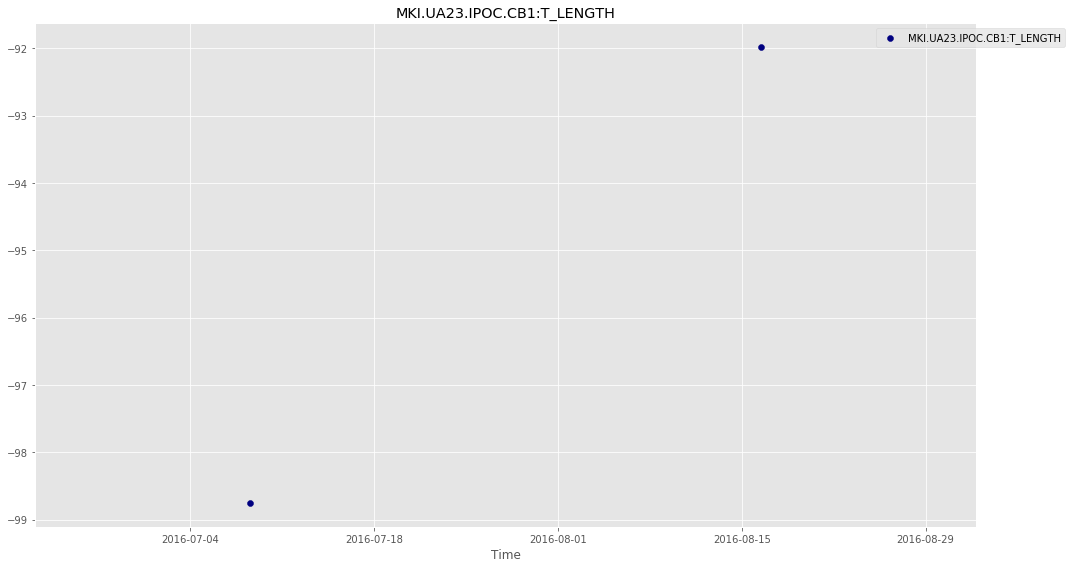

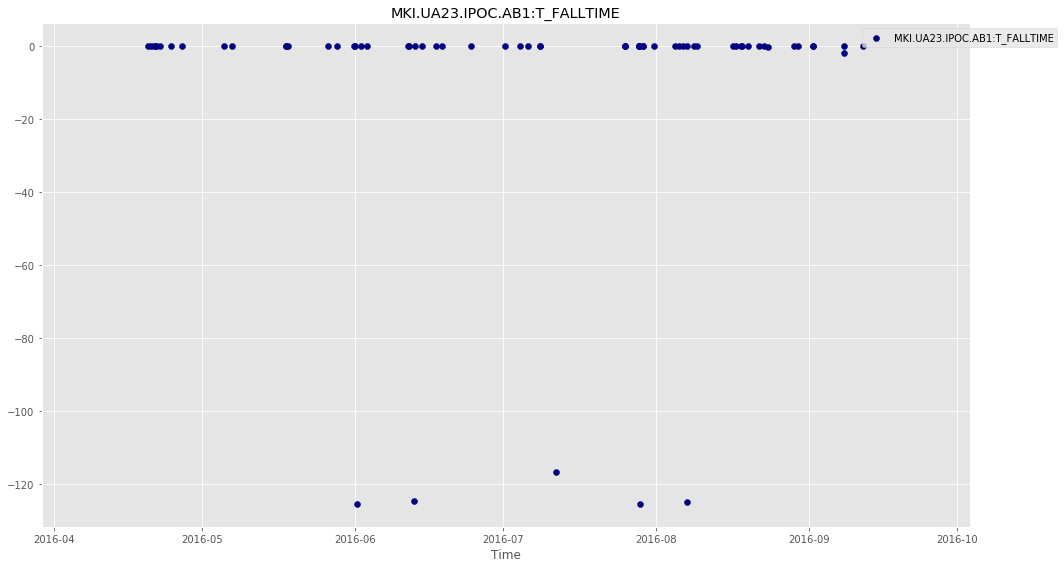

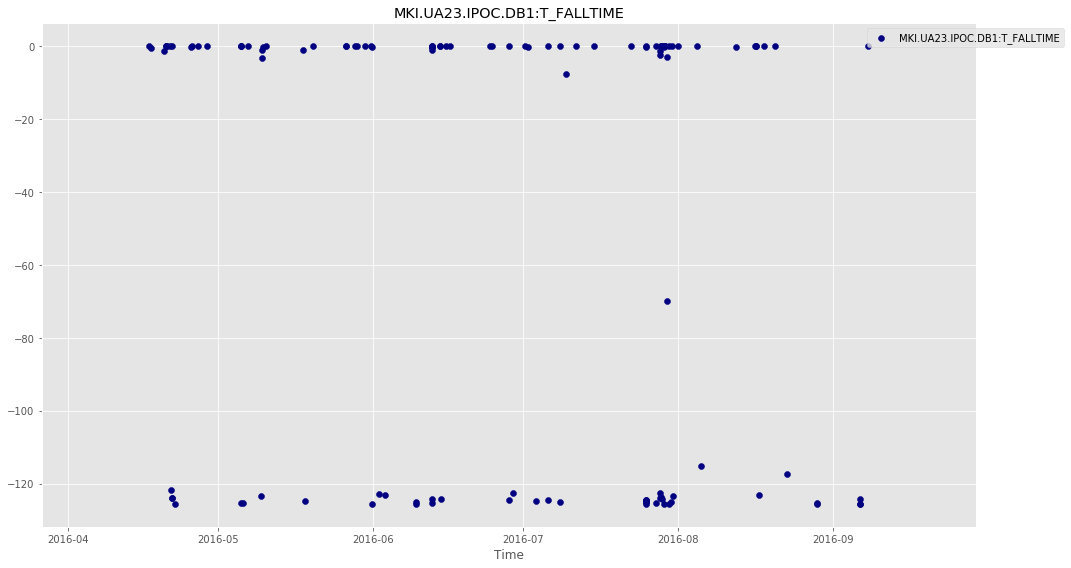

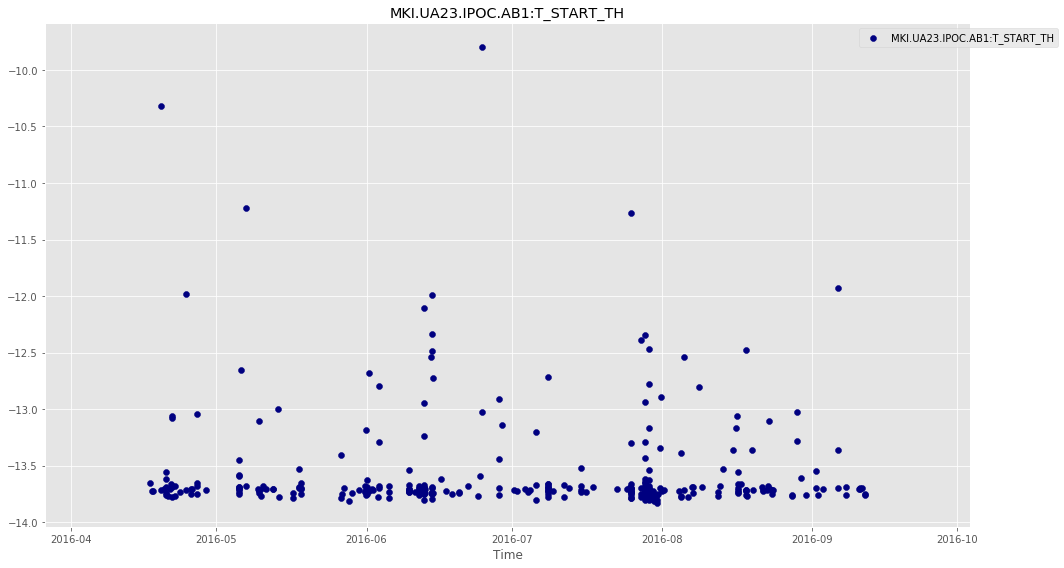

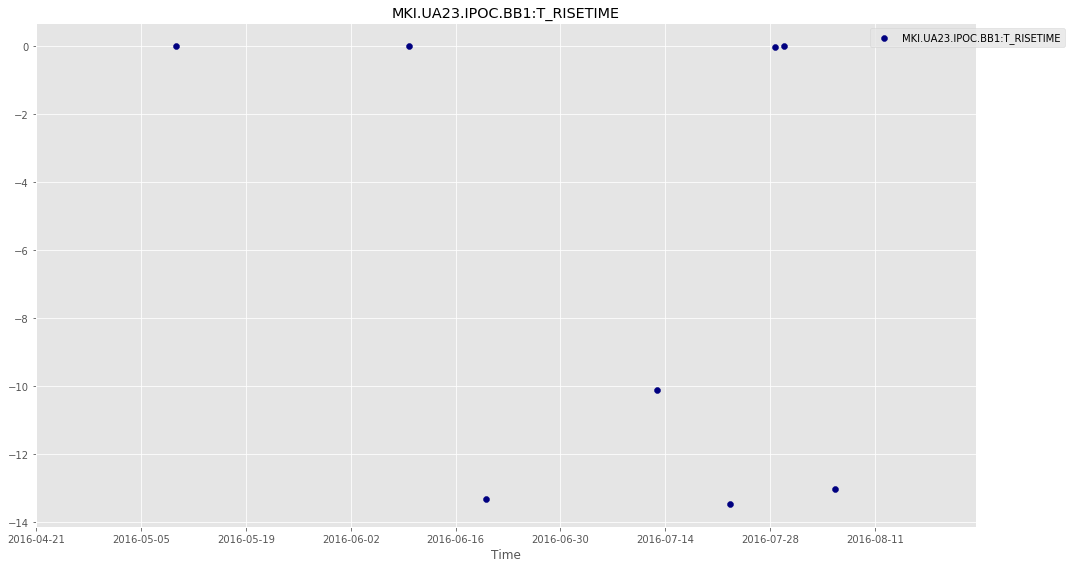

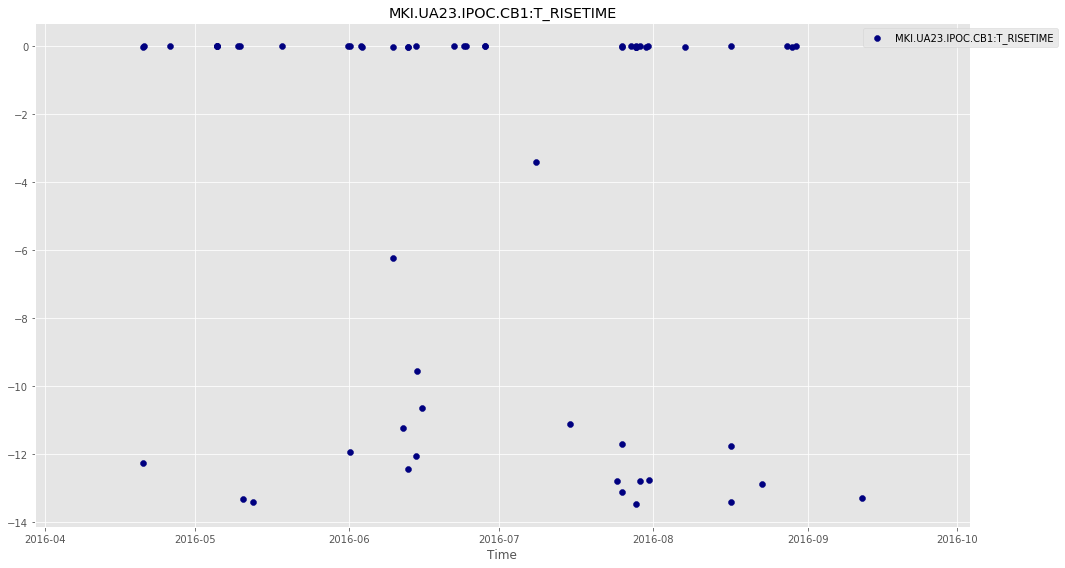

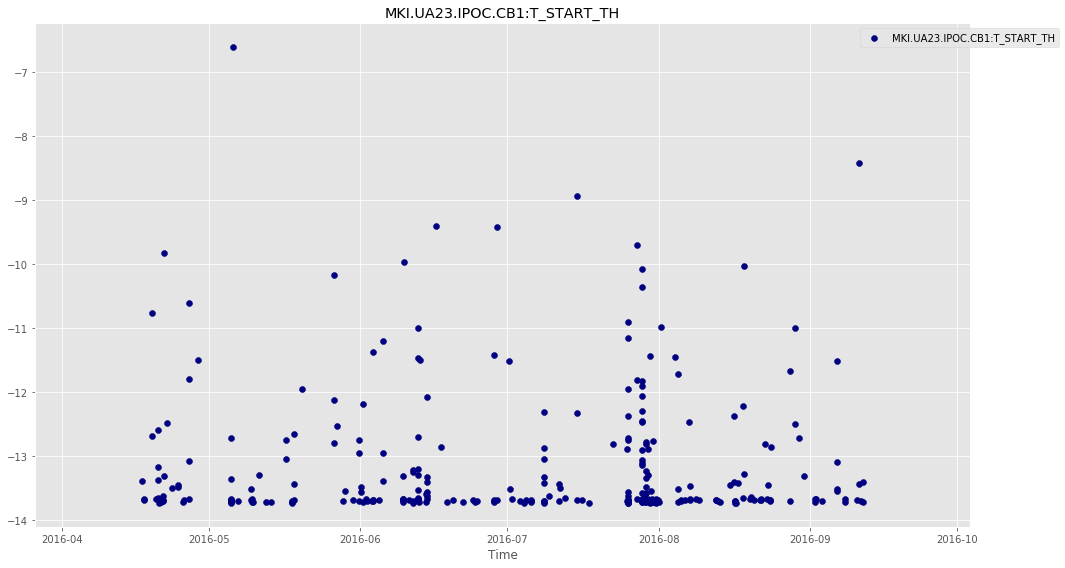

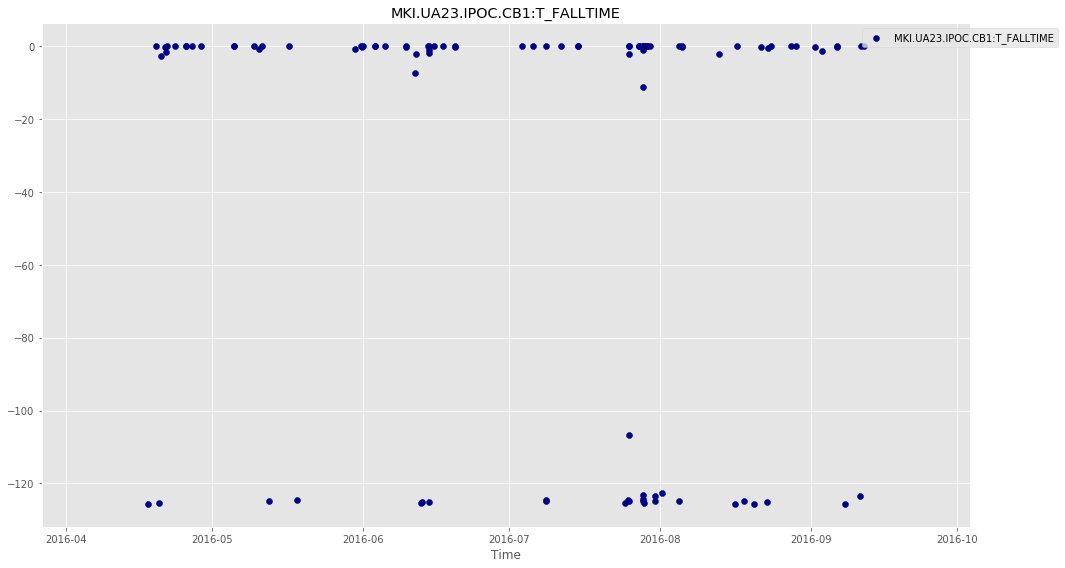

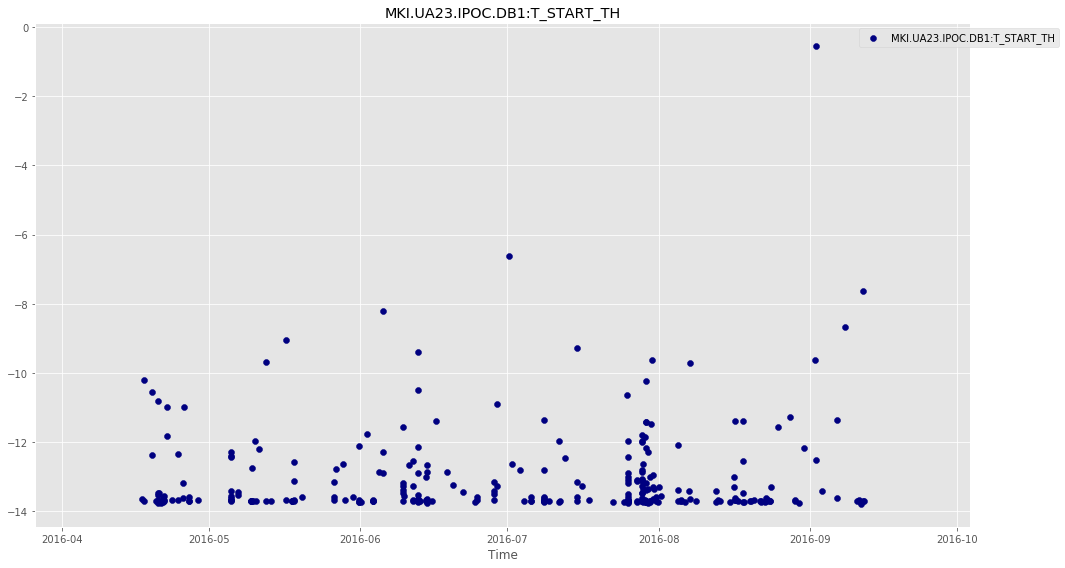

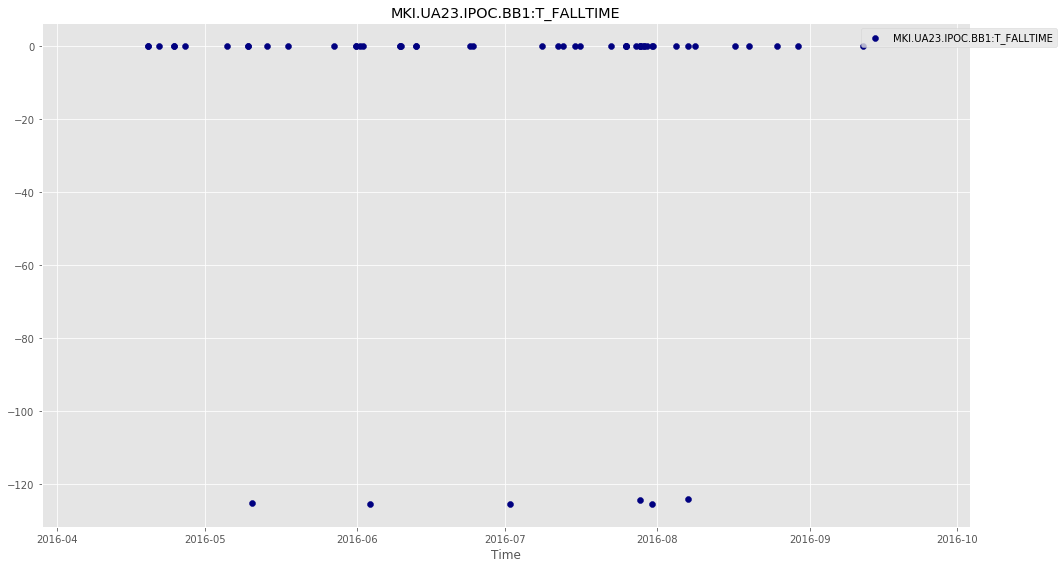

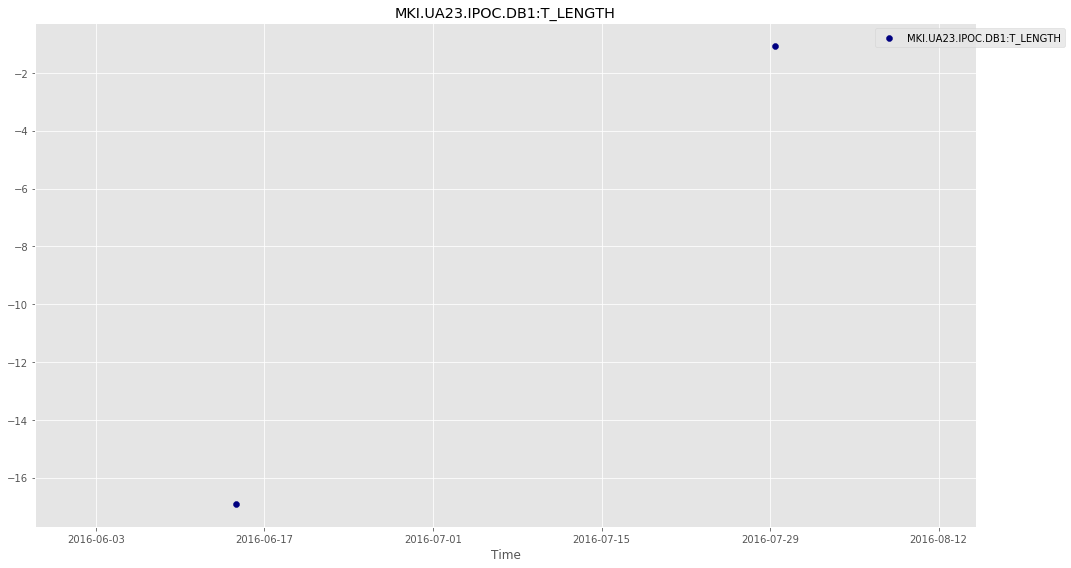

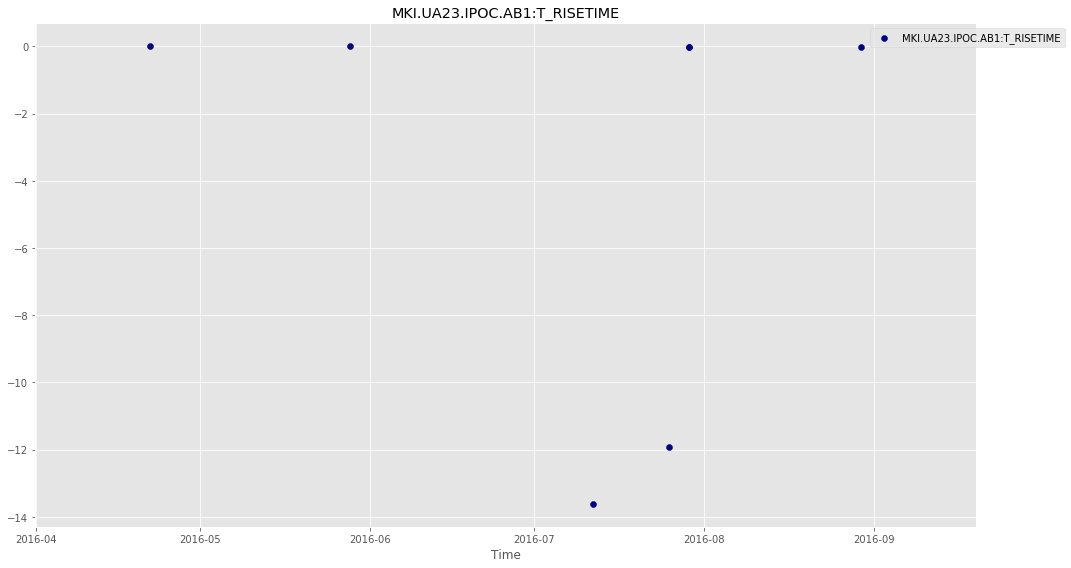

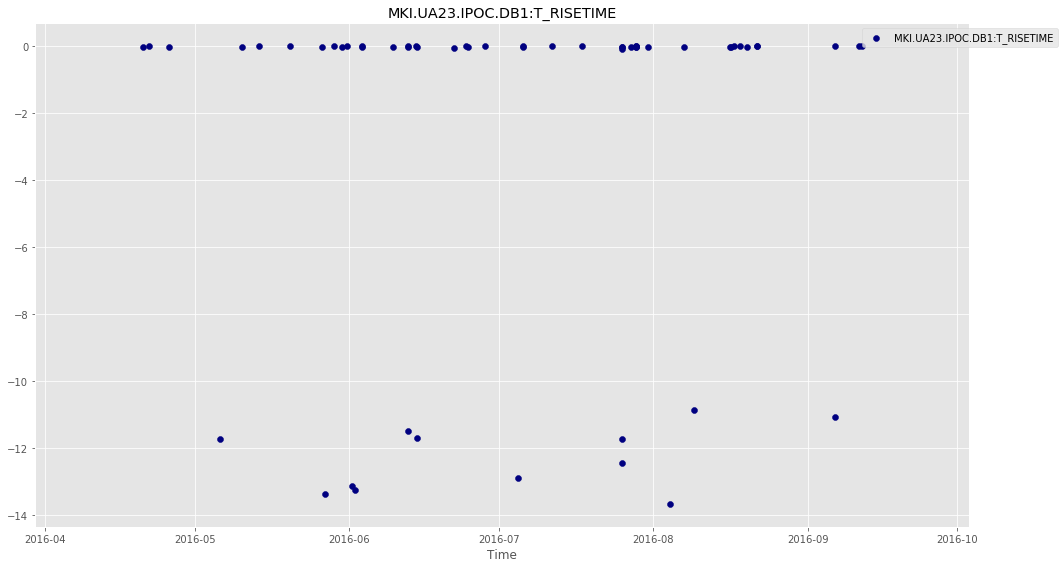

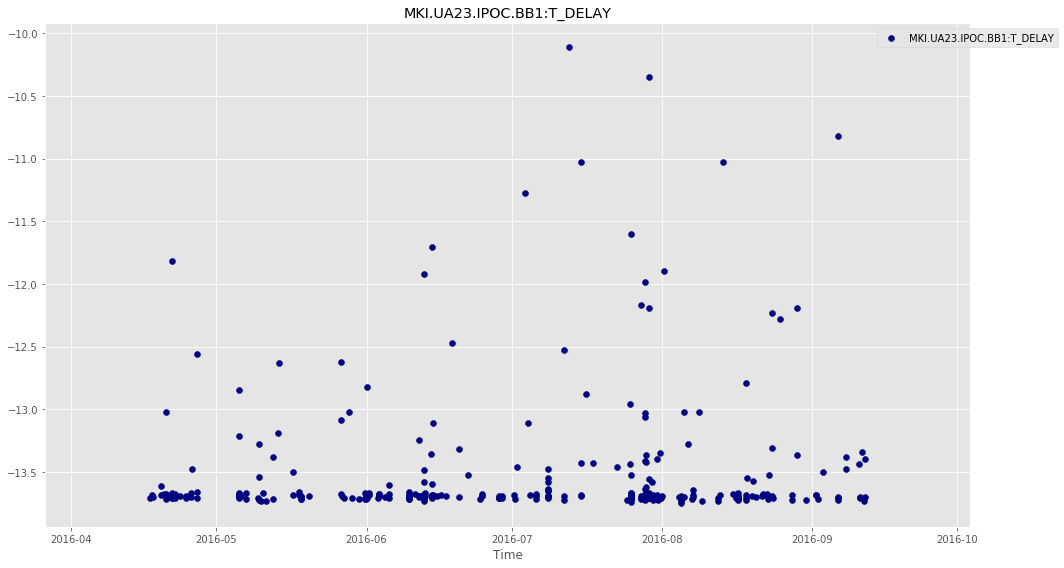

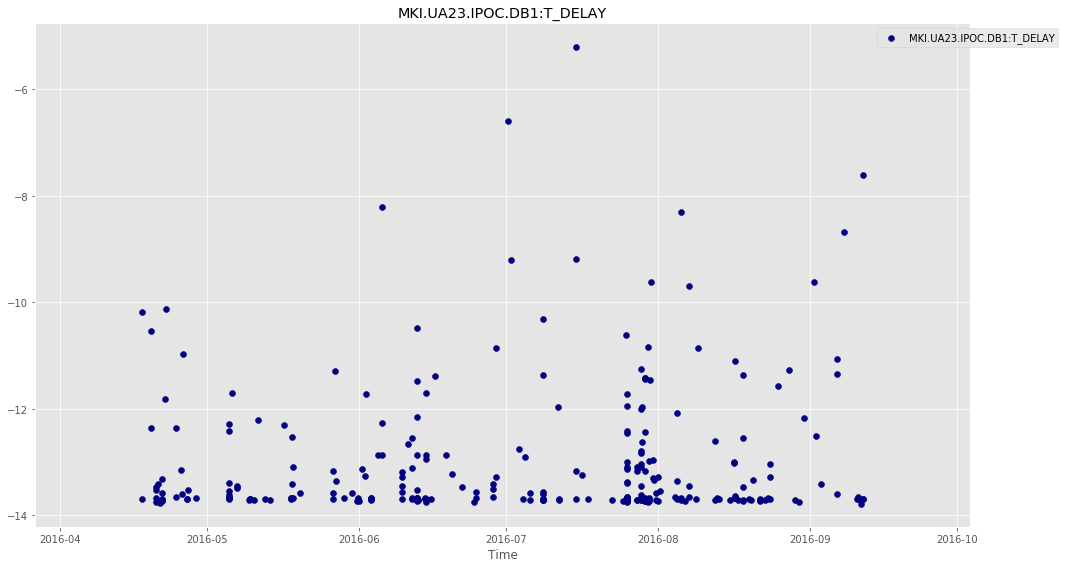

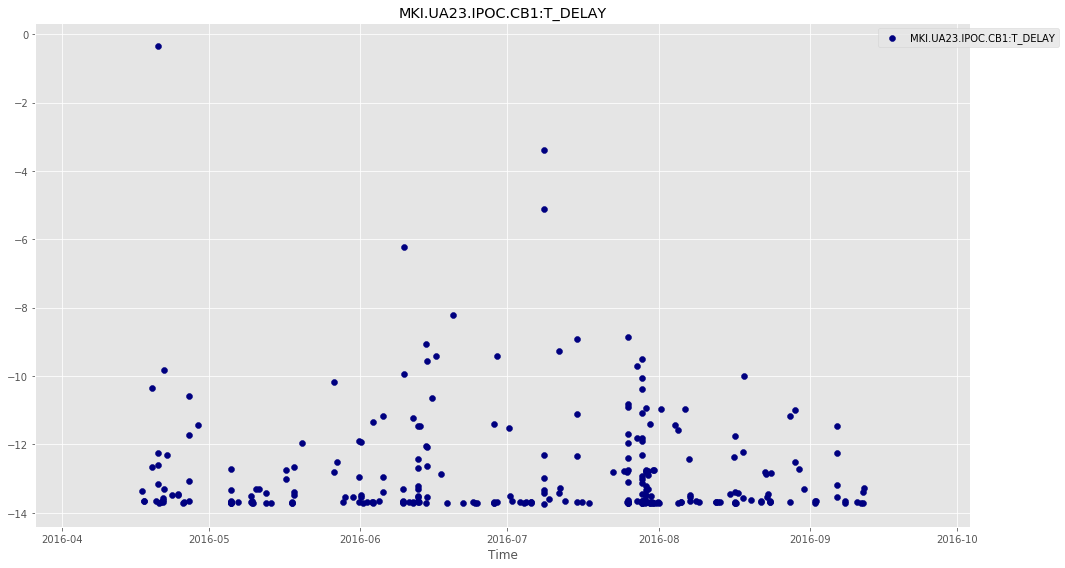

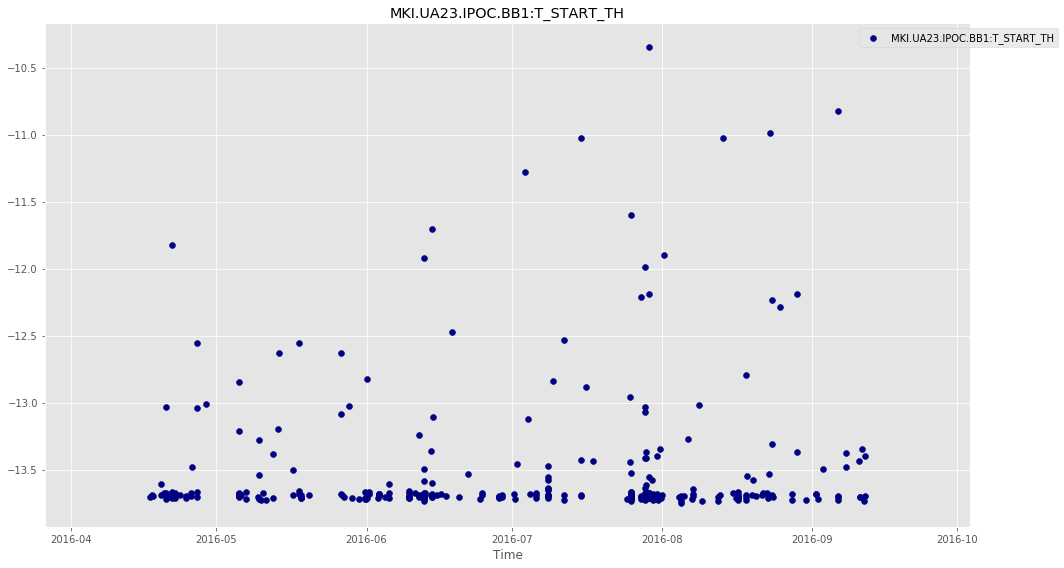

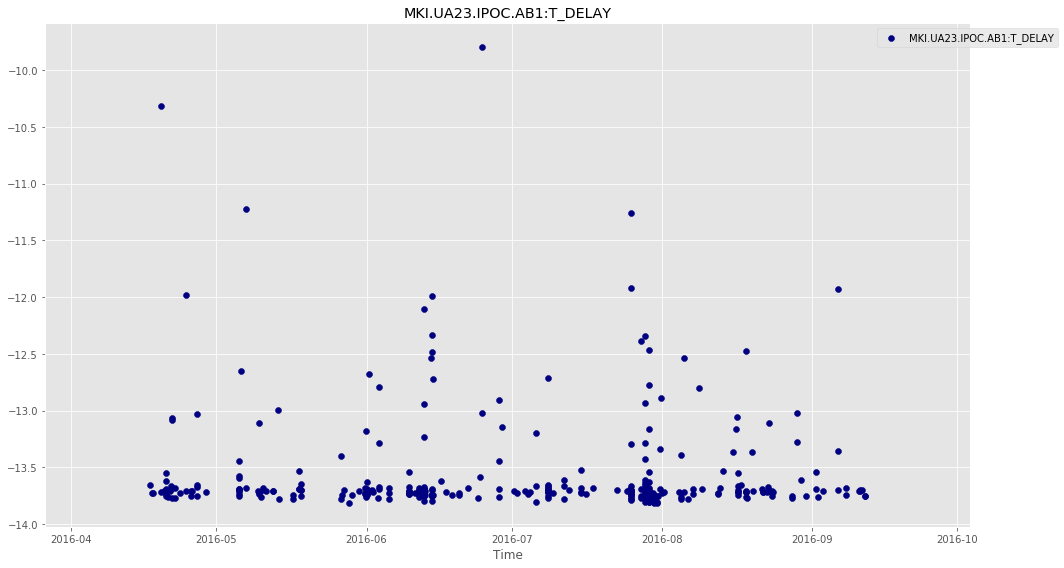

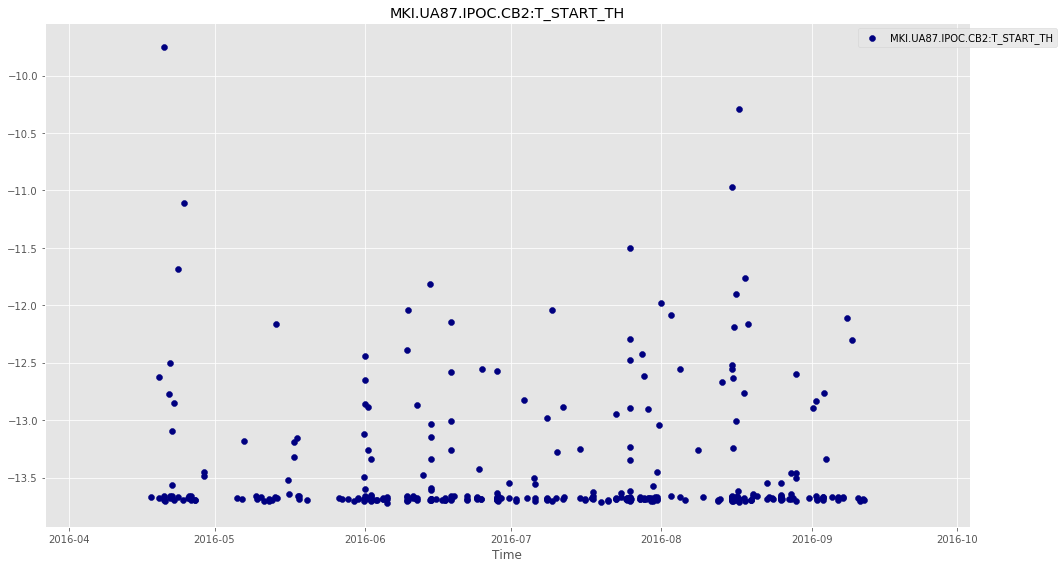

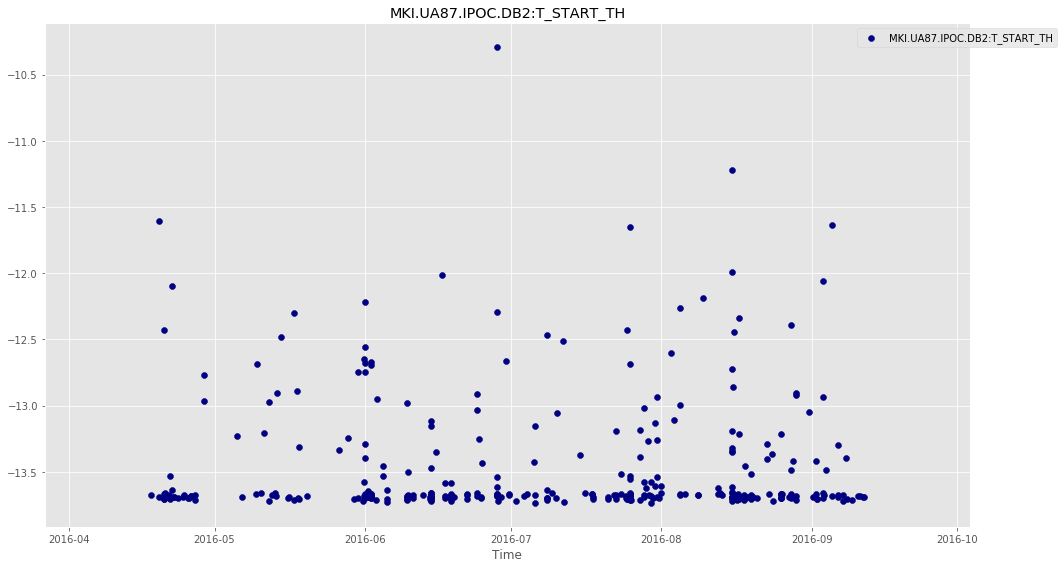

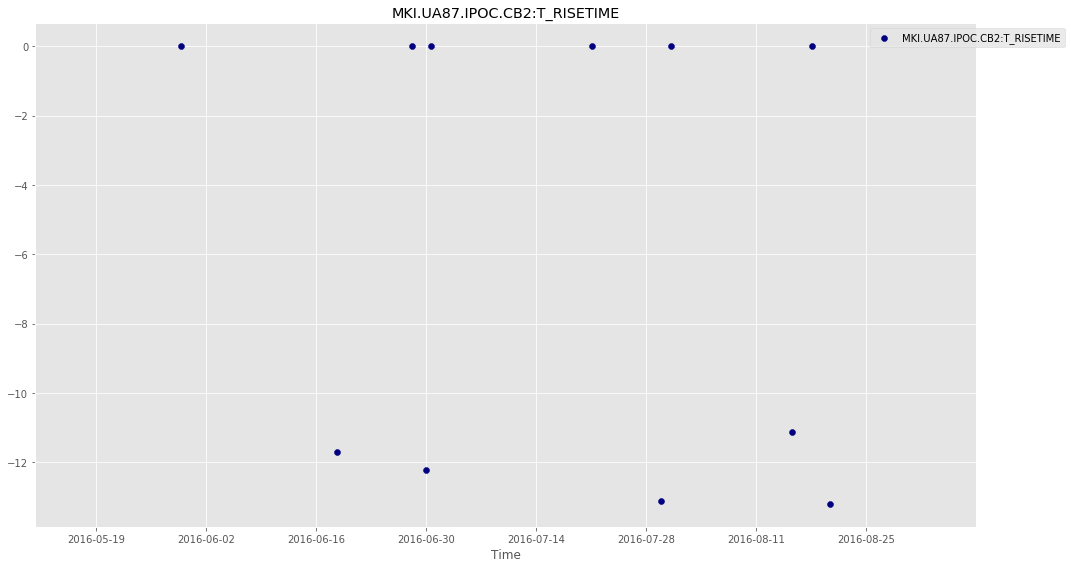

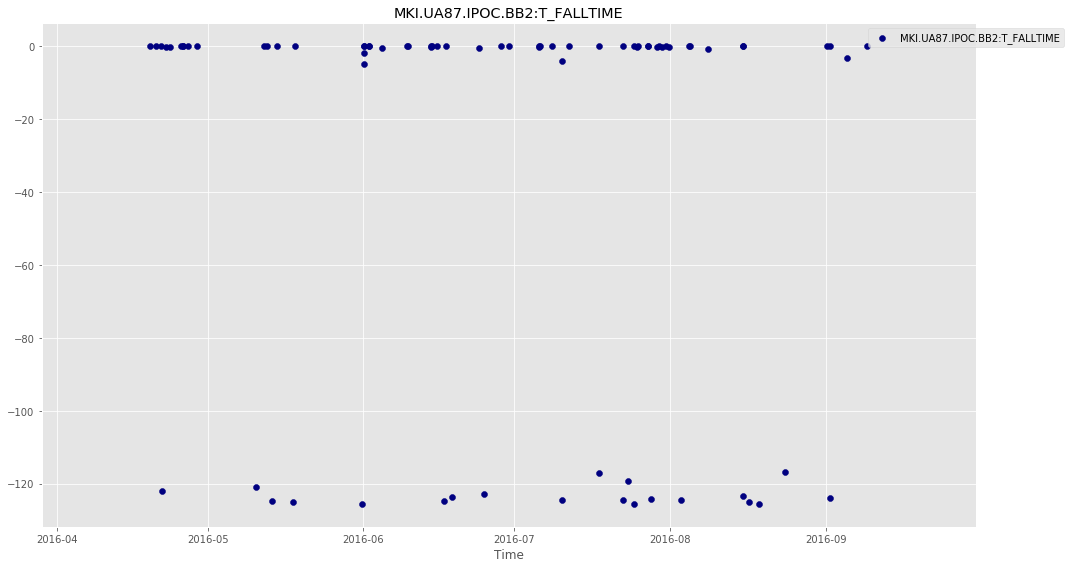

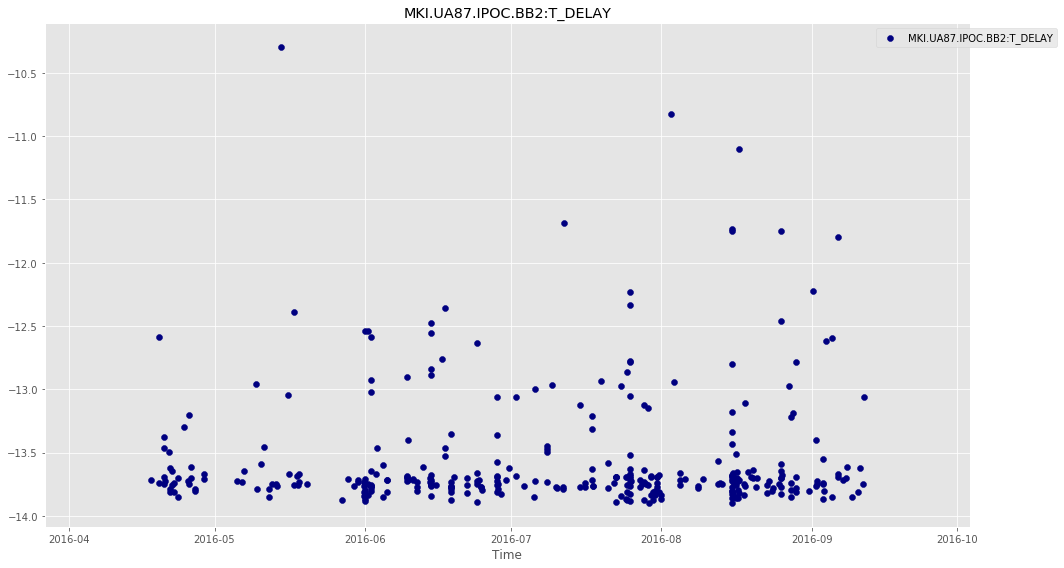

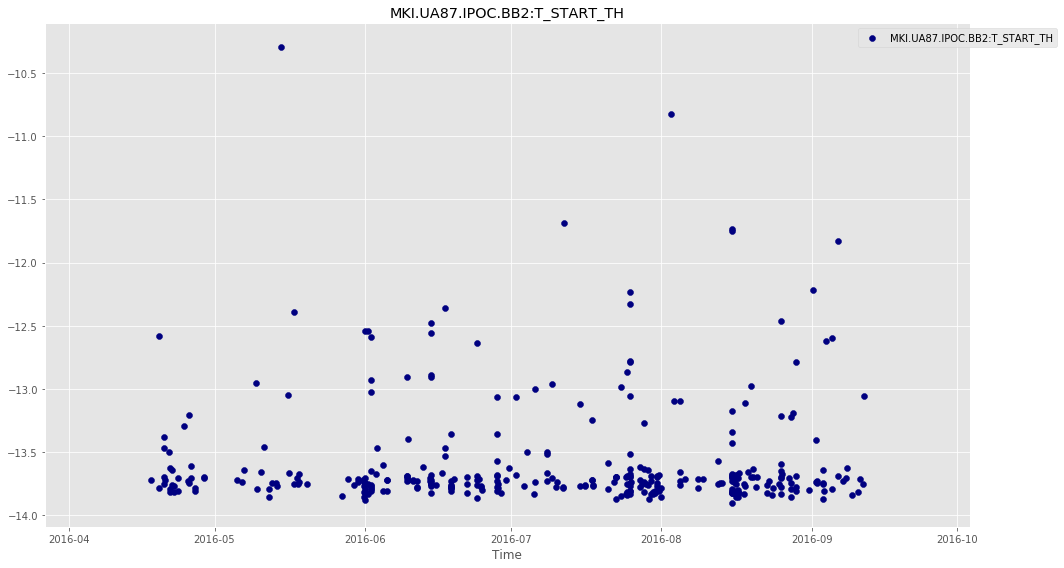

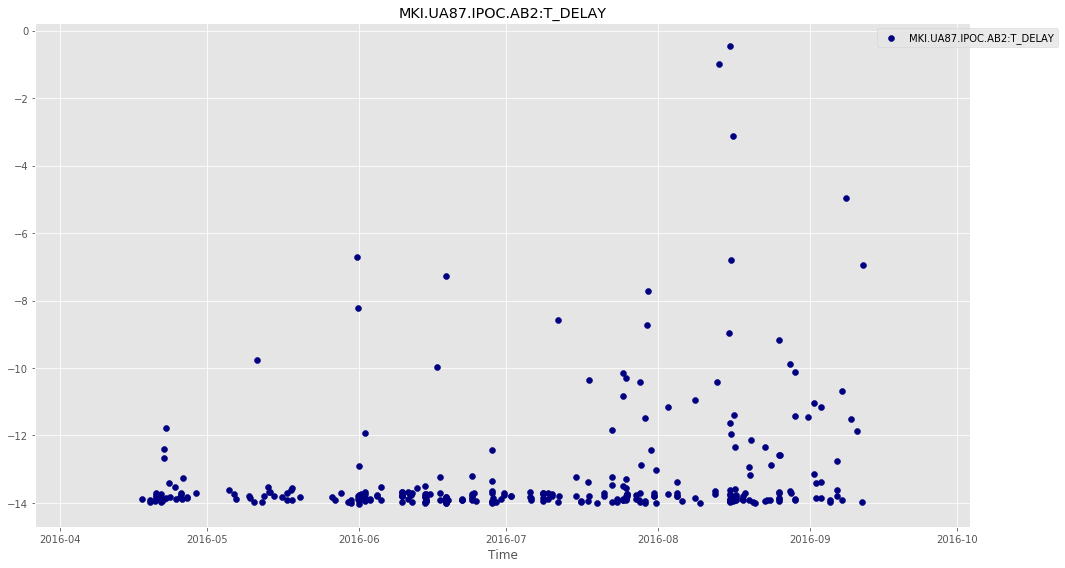

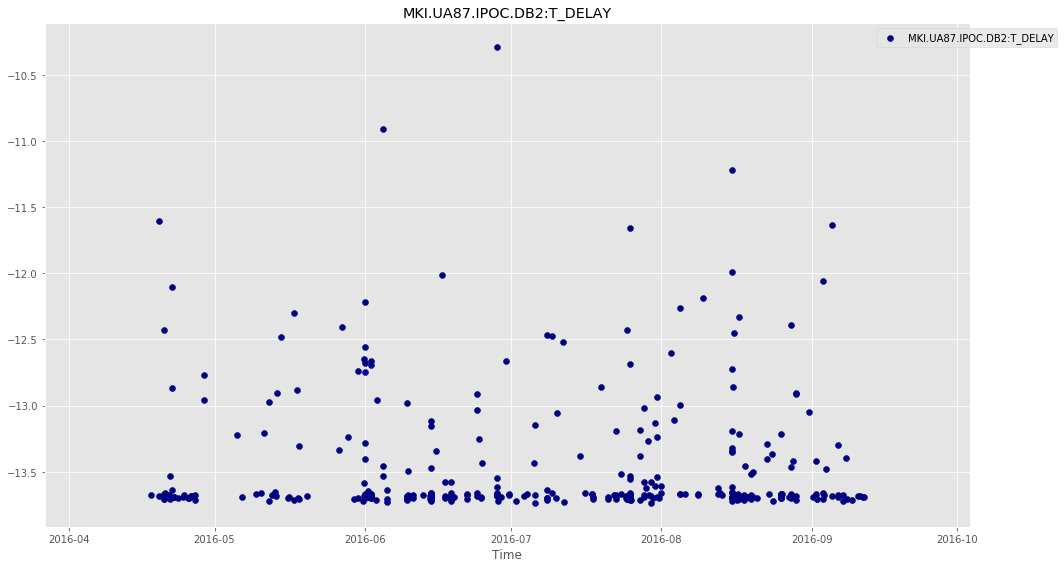

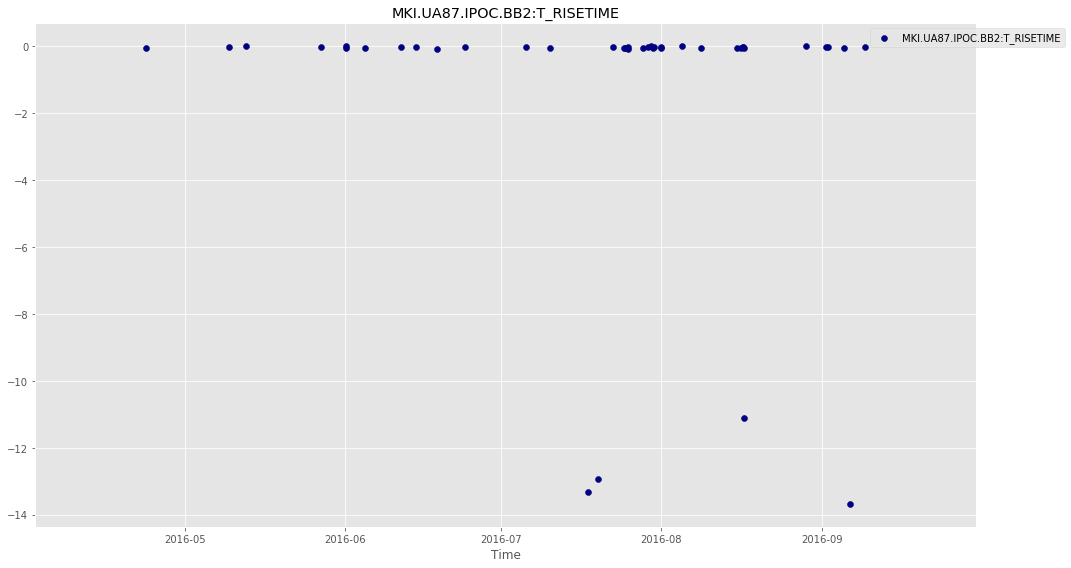

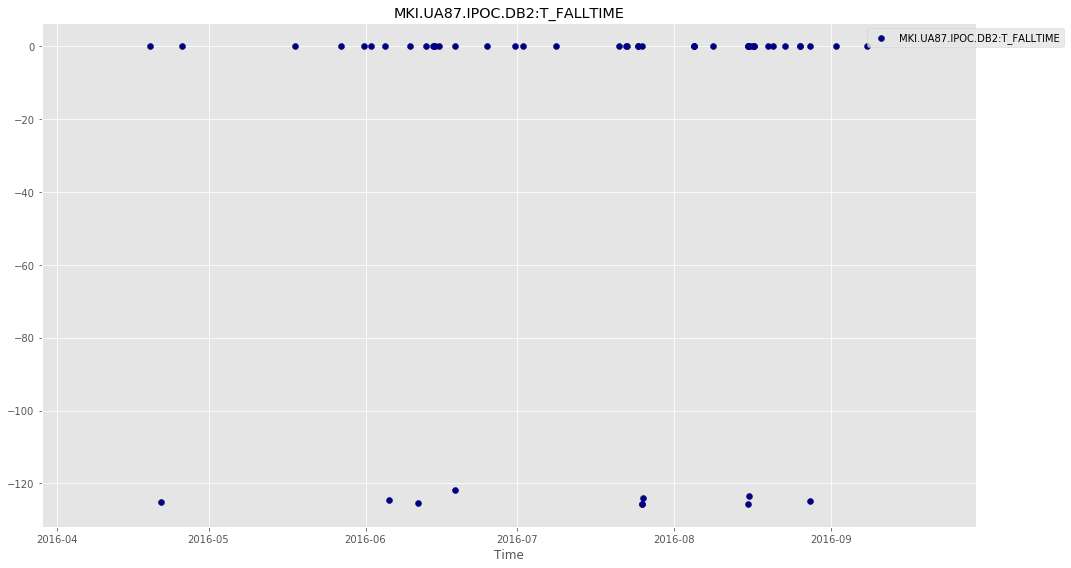

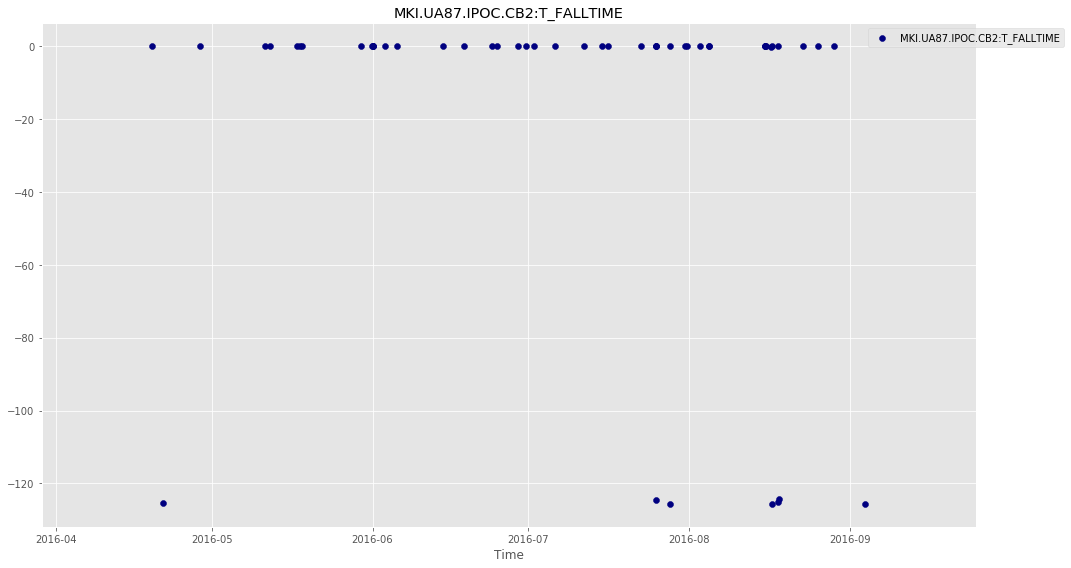

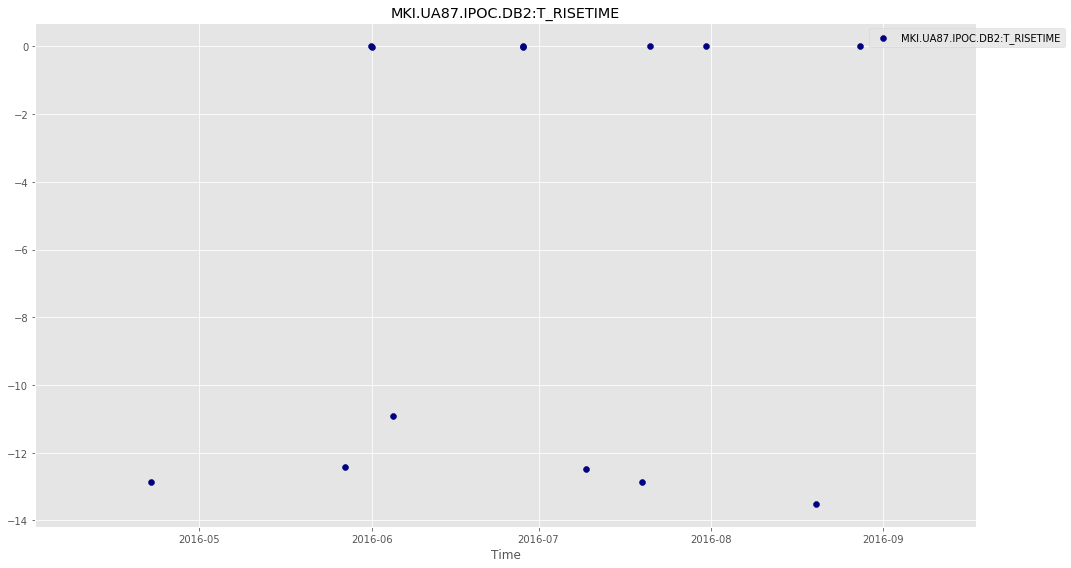

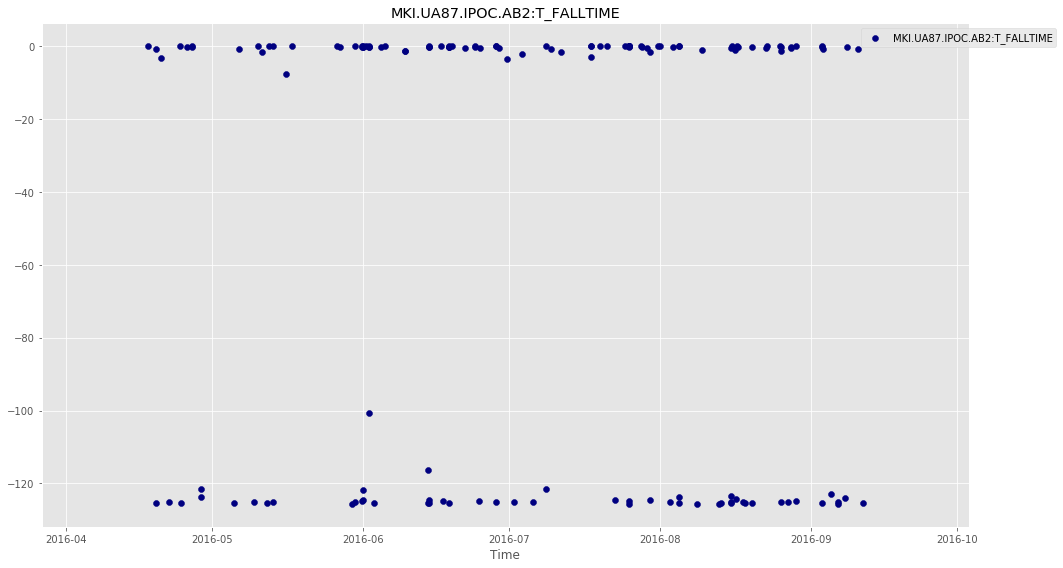

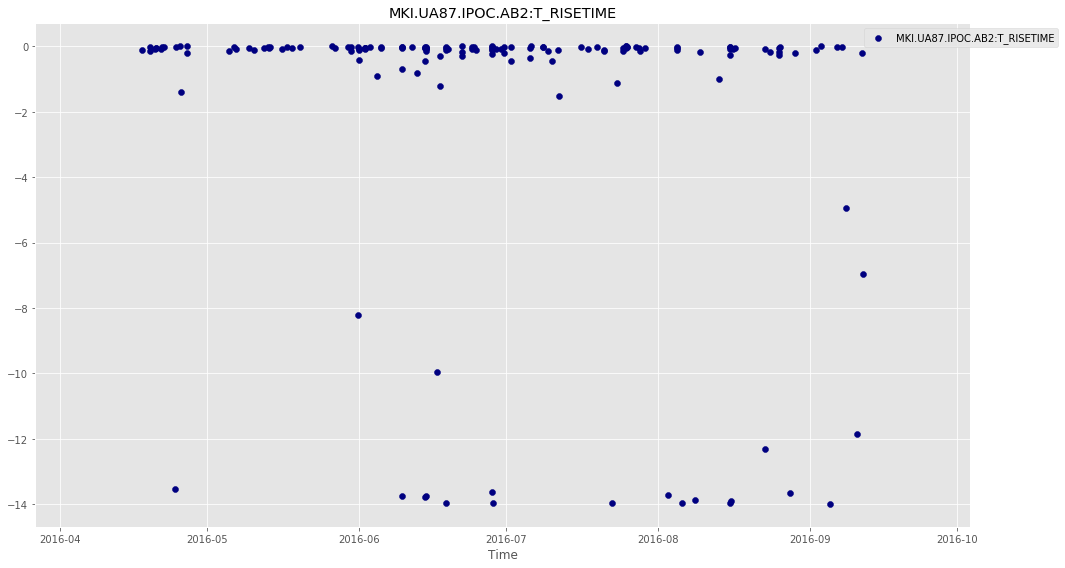

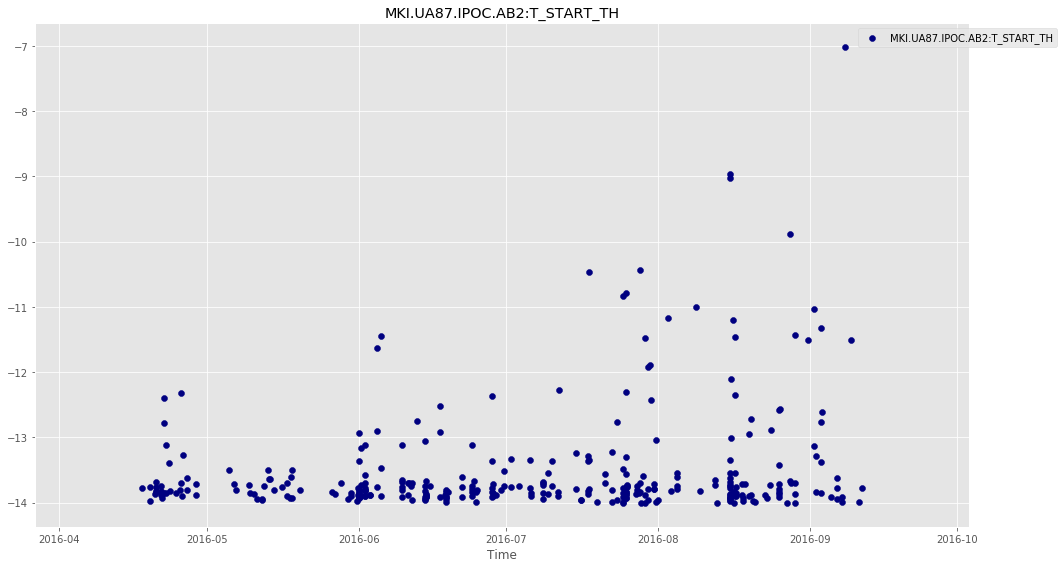

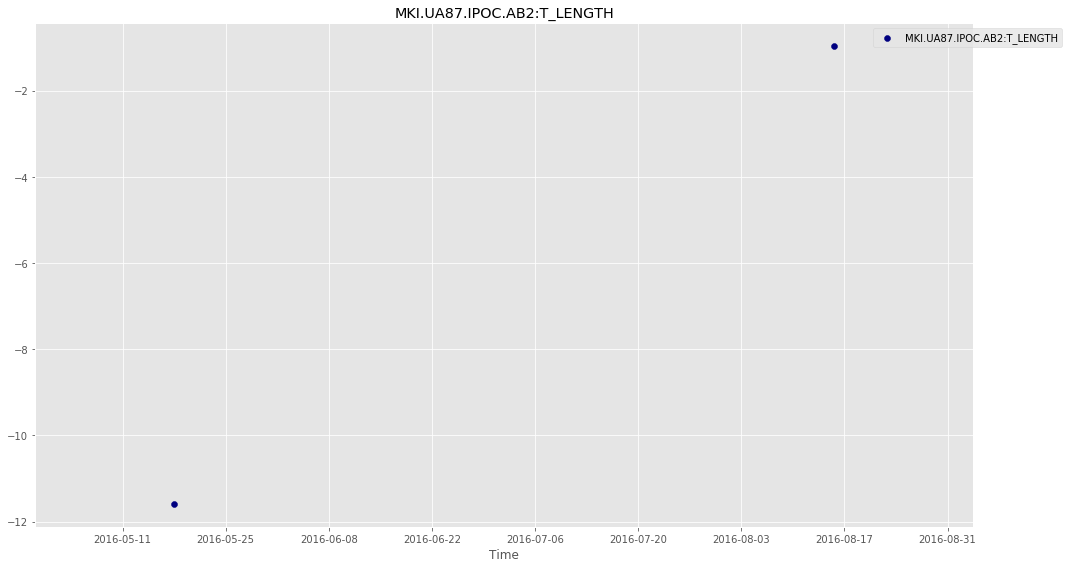

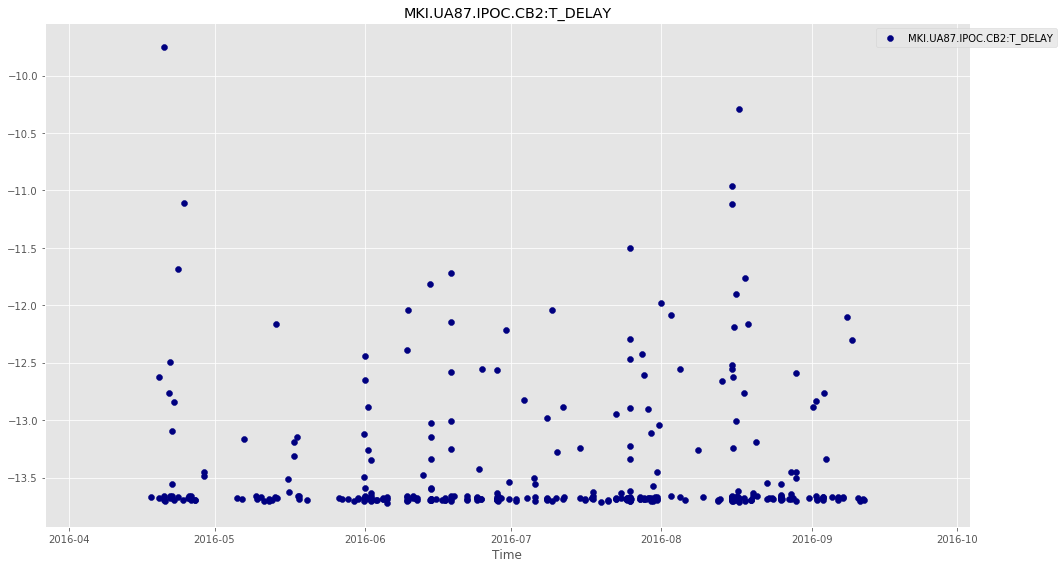

In [9]:
for c, negatives in negatives_dfs:
    plot.data.ipoc(pd.DataFrame(negatives), c)

In [10]:
features = feature_extraction.load_features_from_file("features_b1*")

Loading file '/home/n/masters-thesis/src/../data-cern/features_b1*'.
File not found, loading '/home/n/masters-thesis/src/../data-cern/features_b1_sw-30min_2018-02-23.csv' instead.



In [11]:
print("FEATURES")
total = (features < 0).sum().sum()
print("Amount of negative values:", total)
print("Dataset count:            ", features.count().sum())
print("Ratio:                    ", total / features.count().sum())
print("Shape:                    ", features.shape)
print()

features_f = preprocessing.filter_extremes(features)

print("FEATURES FILTERED")
total = (features_f < 0).sum().sum()
print("Amount of negative values:", total)
print("Dataset count:            ", features_f.count().sum())
print("Ratio:                    ", total / features_f.count().sum())
print("Shape:                    ", features_f.shape)
print()

FEATURES
Amount of negative values: 608572
Dataset count:             4055920
Ratio:                     0.15004536578630742
Shape:                     (46090, 88)

FEATURES FILTERED
Amount of negative values: 608572
Dataset count:             4055920
Ratio:                     0.15004536578630742
Shape:                     (46090, 88)

